# Projet 4 : Anticipez les besoins en consommation électrique de bâtiments

**Contenu du notebook**

- Ce notebook regroupe les parties ***Optimisation des modèles de prédiction*** et ***évaluation des modèles*** pour les deux variables cibles : *Consommation totale d'énergie* et *émissions de CO²*. 
- ***L'effet de l'Energy Star Score*** sur la prédiction des émissions de CO² est abordé en partie 4. 

### Importation des librairies

In [1]:
import re

import lightgbm as lgb
import pandas as pd
import pingouin as pg
import math
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
import xgboost as xgb

from scipy.stats import stats, kstest, probplot
from sklearn import decomposition, kernel_ridge, preprocessing, set_config
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, explained_variance_score, median_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer
from sklearn.svm import LinearSVR
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot

from Pélec_03_utils import *

C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import sklearn
sklearn.__version__

'1.0.2'

In [3]:
xgb.__version__

'1.5.0'

In [4]:
lgb.__version__

'2.3.0'

In [5]:
import yellowbrick
yellowbrick.__version__

'1.3.post1'

### Paramètres graphiques

In [6]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = "{:,.3f}".format

In [7]:
# Graphical parameters #
%matplotlib inline  
from matplotlib import rc
rc={'font.size' : 14, 
    'font.family' : 'Arial',
    'axes.labelsize': 14,   
    'legend.fontsize': 12, 
    'axes.titlesize': 14, 
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12, 
    'figure.max_open_warning': 30}

sns.set(font = 'Arial', rc=rc)
sns.set_style("whitegrid", {'axes.edgecolor': 'k', 
                        'axes.linewidth': 1, 
                        'axes.grid': False,
                        'xtick.major.width': 1,
                        'ytick.major.width': 1})
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 1.5})
dpi=600

In [8]:
set_config(display="diagram")

### Fonctions

In [9]:
def adj_r2(estimator, X, y_true):
    """
        Description: compute adjusted r² between two arrays
    
    Args:
        - estimator: model that need to be scored
        - X (dataframe) : feature matrix
        - y_true (np.array): array of observed (i.e. true) values
        
    Return :
        - Value of adjusted r² between predicted and observed values
    """
    n, p = X.shape
    pred = estimator.predict(X)
    return 1 - ((1 - r2_score(y_true, pred)) * (n - 1))/(n-p-1)

In [10]:
def update_summary(summary, preprocess_param, model, model_name, X_train, X_test, y_train, y_test, transformed_target):
    """
    Description: update summary of modeling results
    
    Args:
        - summary (dataframe): sumary of modeling results
        - preprocess_param (dict): dictionnary of preprocessing data
        - model : model to use (can be a pipeline)
        - model_name (str): name of the model
        - X_train, X_test (dataframes) : training and validation set of explanatory variables
        - y_train, y_test (arrays) : arrays of training and validation set of target values
        - transformed_target (bool): indicate whether target should be log transformed or not
        
    Return :
        - updated summary of modeling results
    """

    if transformed_target:
        # Transform target variable
        model_transf = TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp, check_inverse=True)
    else:
        model_transf = model

    # Fit model
    model_transf.fit(X_train, y_train)
    
    # Prédictions (force to be positive)
    y_train_pred = model_transf.predict(X_train)
    y_train_pred[y_train_pred<0]=0
    y_test_pred = model_transf.predict(X_test)
    y_test_pred[y_test_pred<0]=0
    
    # Remplissage de la table
    summary = summary.append({'preprocess':preprocess_param, 'Nom_modele':model_name, 
                              'r2_train':model_transf.score(X_train, y_train), 'r2_test':model_transf.score(X_test, y_test), 
                              'adj_r2_train':adj_r2(model_transf, X_train, y_train), 'adj_r2_test':adj_r2(model_transf, X_test, y_test), 
                              'msle_train':mean_squared_log_error(y_train, y_train_pred), 'msle_test':mean_squared_log_error(y_test, y_test_pred),
                              'medAbsError_train':median_absolute_error(y_train, y_train_pred), 'medAbsError_test':median_absolute_error(y_test, y_test_pred),
                              'mse_train':mean_squared_error(y_train, y_train_pred), 'mse_test':mean_squared_error(y_test, y_test_pred),
                              'rmse_train':mean_squared_error(y_train, y_train_pred, squared=False), 'rmse_test':mean_squared_error(y_test, y_test_pred, squared=False),
                              'explained_var_train':explained_variance_score(y_train, y_train_pred), 'explained_var_test':explained_variance_score(y_test, y_test_pred)
                              }, ignore_index=True)
    return(summary)

In [11]:
def update_gridsearch_summary(summary, model_name, cv, pipeline_best_result, preprocess_param):
    """
    Description: update summary of modeling results following tuning hyperparameter by gridsearchCV
    
    Args:
        - summary (dataframe): sumary of modeling results
        - model_name (str): name of the model
        - cv (int): number of cross-validation folds
        - pipeline_best_result : best model hyperparameters chosen by gridsearchCV
        - preprocess_param (dict): dictionnary of preprocessing data
        
    Return :
        - updated summary of modeling results
    """
      
    summary = summary.append({'preprocess':preprocess_param, 'Nom_modele':model_name,
                            'cross_val_nfolds': cv,
                            'best_param': pipeline_best_result.params,
                            'r2_train':pipeline_best_result.mean_train_r2, 
                            'r2_test':pipeline_best_result.mean_test_r2,
                            'adj_r2_train':pipeline_best_result.mean_train_adj_r2, 
                            'adj_r2_test':pipeline_best_result.mean_test_adj_r2,
                            'medAbsError_train':-pipeline_best_result.mean_train_neg_median_absolute_error,
                            'medAbsError_test':-pipeline_best_result.mean_test_neg_median_absolute_error,
                            'mse_train':-pipeline_best_result.mean_train_neg_mean_squared_error,
                            'mse_test':-pipeline_best_result.mean_test_neg_mean_squared_error,
                            'msle_train':-pipeline_best_result.mean_train_neg_mean_squared_log_error,
                            'msle_test':-pipeline_best_result.mean_test_neg_mean_squared_log_error,
                            'rmse_train':-pipeline_best_result.mean_train_neg_root_mean_squared_error,
                            'rmse_test':-pipeline_best_result.mean_test_neg_root_mean_squared_error,
                            'explained_var_train':pipeline_best_result.mean_train_explained_variance,
                            'explained_var_test':pipeline_best_result.mean_test_explained_variance,
                            'mean_fit_time': pipeline_best_result.mean_fit_time}, ignore_index=True)
    return(summary)

In [12]:
def gridsearch_pipe(estimator, grid_params, transformed_target, cv, scoring, refit, return_train_score, n_jobs):
    """
    Description: pipeline hyperparameter tuning by gridsearchCV
    
    Args:
        - estimator: estimator to use
        - grid_params (dict): dictionnary containing hyperparameters' names -as keys) and ranges to look at
        - transformed_target (bool):  indicate whether target should be log transformed or not
        - cv (int): number of cross-validation folds
        - scoring (str): strategy to evaluate the performance of the cross-validated model on the test set.
        - refit (str): refit an estimator using the best found parameters on the whole dataset.
        - return_train_score (bool): if False, the cv_results_ attribute will not include training scores.
        - n_jobs (int): number of jobs to run in parallel. -1 means using all processors.
        
    Return :
        - A dict with keys as column headers and values as columns, that can be imported into a pandas DataFrame
    """

    if transformed_target:
        estimator = TransformedTargetRegressor(regressor=estimator, func=np.log, inverse_func=np.exp, check_inverse=True)

    gridsearch_pipeline = GridSearchCV(
      estimator=estimator,
      param_grid=grid_params, 
      cv=cv,
      n_jobs=n_jobs, 
      scoring=scoring,
      refit=refit, 
      return_train_score=return_train_score, error_score="raise")
    return(gridsearch_pipeline)

In [13]:
def get_modelCV_output(model):
    """
    Description: get hyperparameters set and metrics scores corresponding to the best model refited by gridSearchCV
    
    Args:
        - model: model entered as estimator in gridSearchCv (can be a pipeline)
        
    Return :
        - scores on training and cross-validation sets of the best model found by gridSearchCV
    """

    result = pd.DataFrame(model.cv_results_)
    best_res = result.loc[model.best_index_]
    print(best_res.params)
    return(best_res)

In [14]:
def run_hyperparameter_tuning(pipe_name, grid_params, model_name, preprocess_param, summaryGridSearchCV, X_train, y_train, transformed_target=True, 
                              cv=5, scoring='r2', refit='r2', return_train_score=True, n_jobs=-1):
    """
    Description: run hyperparameter tuning process and summary update
    
    Args:
        - pipe_name: estimator to use
        - grid_params (dict): dictionnary containing hyperparameters' names -as keys) and ranges to look at
        - model_name (str): name of the model
        - preprocess_param (dict): dictionnary of preprocessing data
        - summaryGridSearchCV (dataframe): sumary of modeling results
        - X_train (dataframe) : training set of explanatory variables
        - y_train (array) : arrays of training set of target values
        - transformed_target (bool):  indicate whether target should be log transformed or not (defaul: True)
        - cv (int): number of cross-validation folds
        - scoring (str): strategy to evaluate the performance of the cross-validated model on the test set (default: 'r2')
        - refit (str): refit an estimator using the best found parameters on the whole dataset (default: 'r2').
        - return_train_score (bool): if False, the cv_results_ attribute will not include training scores (default: True.
        - n_jobs (int): number of jobs to run in parallel. Default: -1 means using all processors.
        
    Return :
        - updated summary of hyperparameter tuning
    """

    # Build pipeline
    gridPipeline = gridsearch_pipe(pipe_name, grid_params, transformed_target, cv, scoring, refit, return_train_score, n_jobs)
    
    # Fit
    gridPipeline.fit(X_train, y_train)
    
    # Recupère les résultat
    best_res = get_modelCV_output(gridPipeline)
    
    # Mise à jour du dataframe de résultats
    summaryGridSearchCV = update_gridsearch_summary(summaryGridSearchCV, model_name, cv, best_res, preprocess_param)
    return(summaryGridSearchCV)


In [15]:
def get_pipeline_feature_names(pipeline):
    """
    Description: get features names of pipeline
    
    Args:
        - pipeline: estimator to use
        
    Return :
        - list of features names after pipeline pre-processing
    """

    new_features_names = []
    for _, step in pipeline.named_steps.items():    
        if hasattr(step, "get_feature_names"):
            for step_name, pipe, variables in step.transformers_:
                if step_name == 'cat':
                    features_names = pipe.get_feature_names()

                    for feature in features_names:
                        idx = int(feature.split('_')[0][1])
                        new_feature_name = variables[idx] + "_" + feature.split('_')[1]
                        new_features_names.extend([new_feature_name])
                else:
                    new_features_names.extend(variables)
    return(new_features_names)

In [16]:
def evaluate_model(model, X_train, y_train, X_test, y_test, n_var=10, hue='PrimaryPropertyType_reduced', color='lightblue',  model_name_for_figsave="undefined"):
    """
    Description: draw and save plots for model evaluation
    
    Args:
        - model (dataframe): model to use
        - X_train, X_test (dataframes) : training and validation set of explanatory variables
        - y_train, y_test (arrays) : arrays of training and validation set of target values
        - n_var (int): number of the first features to plot (default:10)
        - hue (str); name of the grouping variable (must be a column name of X_train and X_test)
        - color (str):colors of the markers for log-transformed data  (default :'lightblue')
        - model_name_for_figsave : name of the model that will be used for all saved plots (default:'undefined')
        
    Return :
        - plot feature importance, prediction error plots for all dataset and potentiallty by grouping variable, and residuals plot.
    """    
      
    # Importance des variables
    print("IMPORTANCE DES VARIABLES")
    plot_feature_importance(model, n_var, figsize=(10, 8), figsave=str('figures/' + model_name_for_figsave + '_feature_importance.png'))
    
    # Prédictions
    print("PREDICTIONS")
    y_test_predmodel = model.predict(X_test)
    plot_predictions(model, X_train, y_train, X_test, y_test, y_test_predmodel, color=color, savefig=str('figures/' + model_name_for_figsave + '_predictions.png'))
    
    # Predictions par type de batiment
    if hue:
        print("PREDICTIONS PAR TYPE DE BATIMENT")
        plot_predictions(model, X_train, y_train, X_test, y_test, y_test_predmodel,hue=hue, color=color, savefig=str('figures/' + model_name_for_figsave + '_predictions_By' + hue + '.png'))
    
    # Residus
    print("DISTRIBUTION DES RESIDUS")
    visualizer = ResidualsPlot(model, hist=False, qqplot=True, is_fitted=True)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show() 

# Partie 1 - Importation des données nettoyées

In [17]:
dataset = 'cleaned_data_ManualSel_160222.csv'

In [18]:
df = pd.read_csv(dataset)
print(df.shape)
df.head()

(1689, 27)


,BuildingAge,BuildingType,PrimaryPropertyType,PrimaryPropertyType_reduced,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,steam01,elec01,gas01,otherFuels01,steamPart,elecPart,gasPart,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions
0,95.000,NonResidential,Hotel,Sleeping_places,7,Downtown,1.000,12.000,"88,434.000",0.000,"88,434.000",Hotel,"88,434.000",none,0.000,none,0.000,Yes,Yes,Yes,No,25-50%,50-75%,<25%,60.000,"7,226,362.500",249.980
1,26.000,NonResidential,Hotel,Sleeping_places,7,Downtown,1.000,11.000,"103,566.000","15,064.000","88,502.000",Hotel,"83,880.000",Parking,"15,064.000",Restaurant,"4,622.000",No,Yes,Yes,No,<25%,25-50%,50-75%,61.000,"8,387,933.000",295.860
2,53.000,NonResidential,Hotel,Sleeping_places,7,Downtown,1.000,41.000,"956,110.000","196,718.000","759,392.000",Hotel,"756,493.000",Parking,"100,000.000",Swimming Pool,0.000,Yes,Yes,Yes,No,25-50%,50-75%,<25%,43.000,"72,587,024.000","2,089.280"
3,96.000,NonResidential,Hotel,Sleeping_places,7,Downtown,1.000,10.000,"61,320.000",0.000,"61,320.000",Hotel,"61,320.000",none,0.000,none,0.000,Yes,Yes,Yes,No,25-50%,25-50%,25-50%,56.000,"6,794,584.000",286.430
4,42.000,NonResidential,Hotel,Sleeping_places,7,Downtown,1.000,18.000,"175,580.000","62,000.000","113,580.000",Hotel,"123,445.000",Parking,"68,009.000",Swimming Pool,0.000,No,Yes,Yes,No,<25%,25-50%,50-75%,75.000,"14,172,606.000",505.010


In [19]:
df.describe()

,BuildingAge,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions
count,"1,689.000","1,689.000","1,689.000","1,689.000","1,689.000","1,689.000","1,689.000","1,689.000","1,689.000","1,689.000","1,689.000","1,689.000","1,689.000"
mean,60.261,4.368,1.136,4.047,"113,029.553","13,179.186","99,850.367","92,570.304","19,002.980","3,134.737",65.421,"8,016,686.212",180.757
std,32.804,2.192,1.144,6.107,"193,526.156","43,336.944","171,626.628","159,028.504","53,361.316","17,868.237",23.573,"21,779,794.114",706.728
min,7.000,1.000,1.000,0.000,"11,285.000",0.000,"3,636.000",0.000,0.000,0.000,1.000,"16,808.900",0.120
25%,33.000,2.000,1.000,1.000,"29,258.000",0.000,"28,304.000","25,100.000",0.000,0.000,62.000,"1,252,323.875",20.100
50%,57.000,4.000,1.000,2.000,"49,066.000",0.000,"47,105.000","43,188.000",0.000,0.000,65.421,"2,564,004.000",49.730
75%,92.000,7.000,1.000,4.000,"105,061.000",0.000,"94,500.000","91,532.000","12,717.000",0.000,82.000,"6,859,198.000",142.390
max,122.000,7.000,27.000,76.000,"2,200,000.000","512,608.000","2,200,000.000","1,719,643.000","686,750.000","459,748.000",100.000,"448,385,312.000","16,870.980"


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingAge                      1689 non-null   float64
 1   BuildingType                     1689 non-null   object 
 2   PrimaryPropertyType              1689 non-null   object 
 3   PrimaryPropertyType_reduced      1689 non-null   object 
 4   CouncilDistrictCode              1689 non-null   int64  
 5   Neighborhood                     1689 non-null   object 
 6   NumberofBuildings                1689 non-null   float64
 7   NumberofFloors                   1689 non-null   float64
 8   PropertyGFATotal                 1689 non-null   float64
 9   PropertyGFAParking               1689 non-null   float64
 10  PropertyGFABuilding(s)           1689 non-null   float64
 11  LargestPropertyUseType           1689 non-null   object 
 12  LargestPropertyUseTy

In [21]:
df.loc[:, 'CouncilDistrictCode'] = df.loc[:, 'CouncilDistrictCode'].astype('object')

## Vérification des conditions pour une régression

### Distribution normale

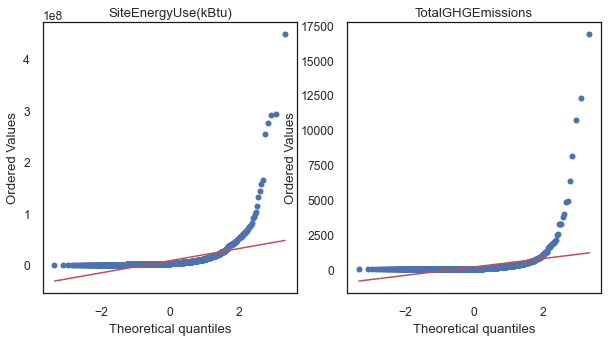

In [22]:
# Distribution normale des variables quantitatives
fig, ax = plt.subplots(1,2, figsize=(10,5))
probplot(df.loc[:, 'SiteEnergyUse(kBtu)'],fit=True, plot=ax[0])
ax[0].set_title('SiteEnergyUse(kBtu)')
probplot(df.loc[:, 'TotalGHGEmissions'], fit=True, plot=ax[1])
ax[1].set_title('TotalGHGEmissions')
plt.savefig('figures/raw_qqplots.png', bbox_inches='tight', dpi=dpi)

=> Les variables  SiteEnergyUse et TotalGHGEmissions ne suivent pas du tout une distriubtion normale.
=> Nous les transformons en log.

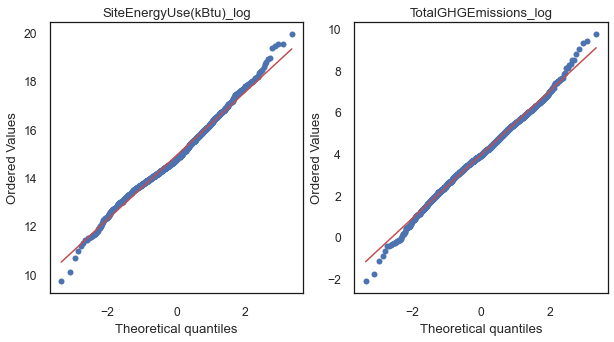

In [23]:
# Distribution normale des variables quantitatives
fig, ax = plt.subplots(1,2, figsize=(10,5))
probplot(np.log(df.loc[:, 'SiteEnergyUse(kBtu)']), fit=True, plot=ax[0])
ax[0].set_title('SiteEnergyUse(kBtu)_log')
probplot(np.log(df.loc[:, 'TotalGHGEmissions']), fit=True, plot=ax[1])
ax[1].set_title('TotalGHGEmissions_log')
plt.savefig('figures/log_qqplots.png', bbox_inches='tight', dpi=dpi)

=> La transformation logarithmique améliore grandement la distribution des variables à prédire.

In [24]:
df.loc[:, 'SiteEnergyUse(kBtu)_log'] = np.log(df.loc[:, 'SiteEnergyUse(kBtu)'])
df.loc[:, 'TotalGHGEmissions_log'] = np.log(df.loc[:, 'TotalGHGEmissions'])

In [25]:
# Test for normality using Kolmogorov test pour distribution normale
ks_res = pd.DataFrame(columns=['variable', 'statistics', 'pvalue'])
for var in ['SiteEnergyUse(kBtu)_log','TotalGHGEmissions_log','SiteEnergyUse(kBtu)','TotalGHGEmissions']:
    ks = kstest(df.loc[:, var], 'norm')
    ks_res = ks_res.append({'variable':var, 'statistics': ks[0], 'pvalue':ks[1]}, ignore_index=True)
ks_res

,variable,statistics,pvalue
0,SiteEnergyUse(kBtu)_log,1.000,0.000
1,TotalGHGEmissions_log,0.887,0.000
2,SiteEnergyUse(kBtu),1.000,0.000
3,TotalGHGEmissions,0.967,0.000


Les variables cibles ne suivent pas une distribution normale, même lorsque transformées en log

### Homogeneité des variances

In [26]:
categorical_var = ['BuildingType', 'PrimaryPropertyType_reduced','CouncilDistrictCode', 'Neighborhood', 
                   'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 
                   'steam01', 'elec01','gas01', 'otherFuels01', 'steamPart', 'elecPart','gasPart']

#### Site Energy Use

In [27]:
# Utilisation du test de Levene car les distributions ne sont pas normales
levene_res = pd.DataFrame(columns=['factor', 'pvalue', 'equal_var'])
for cat in categorical_var:
    lev = pg.homoscedasticity(df, dv='SiteEnergyUse(kBtu)_log', group=cat)
    levene_res = levene_res.append({'factor':cat, 'pvalue': lev.pval[0], 'equal_var':lev.equal_var[0]}, ignore_index=True)
levene_res

,factor,pvalue,equal_var
0,BuildingType,0.000,False
1,PrimaryPropertyType_reduced,0.000,False
2,CouncilDistrictCode,0.000,False
3,Neighborhood,0.009,False
4,LargestPropertyUseType,0.000,False
5,SecondLargestPropertyUseType,0.272,True
6,ThirdLargestPropertyUseType,0.101,True
7,steam01,0.607,True
8,elec01,0.215,True
9,gas01,0.001,False


#### GHGEmissions

In [28]:
levene_res = pd.DataFrame(columns=['factor', 'pvalue', 'equal_var'])
for cat in categorical_var:
    lev = pg.homoscedasticity(df, dv='TotalGHGEmissions_log', group=cat)
    levene_res = levene_res.append({'factor':cat, 'pvalue': lev.pval[0], 'equal_var':lev.equal_var[0]}, ignore_index=True)
levene_res

,factor,pvalue,equal_var
0,BuildingType,0.001,False
1,PrimaryPropertyType_reduced,0.000,False
2,CouncilDistrictCode,0.002,False
3,Neighborhood,0.206,True
4,LargestPropertyUseType,0.000,False
5,SecondLargestPropertyUseType,0.128,True
6,ThirdLargestPropertyUseType,0.201,True
7,steam01,0.042,False
8,elec01,0.220,True
9,gas01,0.000,False


=> on va invoquer le théorème Central limite et dire que l'on a suffisamment d'échantillons pour considérer que les variables cibles sont distribuées normalement et les variances sont homogènes...

# Partie 2 - Prédiction de la consommation en Energy (SiteEnergyUse(kBtu))

## Préparations des modèles

### Préparation des dataframes de stockage des résultats

In [29]:
# Attribution des noms de colonnes et types
dtypes = np.dtype([
        ("preprocess", str), ("Nom_modele", str), ("cross_val_nfolds", int), ("best_param", str),
        ("r2_train", float),("r2_test", float),
        ("adj_r2_train", float),("adj_r2_test", float),
        ("msle_train", float),("msle_test", float),
        ("explained_var_train", float),('explained_var_test',float),
        ("medAbsError_train", float), ("medAbsError_test", float),
        ("mse_train", float), ("mse_test", float),
        ("rmse_train", float), ("rmse_test", float),
        ("mean_fit_time", float)
        ])

In [30]:
# Preparation des dataframe de stockage des résultats
summary = pd.DataFrame(np.empty(0, dtype=dtypes))
summaryGridSearchCV = pd.DataFrame(np.empty(0, dtype=dtypes))

In [31]:
# Nom des résumés à sauver
baseline_summary_name = "summary_baselineModels_Energy_170222_TTR_RobustScaler_Sklearn_1-0-2_SelectedVar_Final_CorrAdjR2.csv"
gridSearch_summary_name = "summaryGridSearchCV_Energy_Tuning_180222_TTR_RobustScaler_train08_adjR2_Sklearn_SelectedVar_1-0-2_Final_CorrAdjR2.csv"

### Variables utilisées

In [32]:
target_var = "SiteEnergyUse(kBtu)"

In [33]:
# Variables explicatives à utiliser
num_var = ['BuildingAge', 'NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore',
           'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 
           'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']
cat_var =  ['BuildingType', 'PrimaryPropertyType_reduced', 'CouncilDistrictCode', 'Neighborhood',
            'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

### Création des jeux d'entrainement et de validation

In [34]:
# Set train size
train_size = 0.8
stratify_var = 'PrimaryPropertyType_reduced'

In [35]:
# Creation jeu de test et train
y = df.loc[:, target_var]
X = df.loc[:, num_var + cat_var]

X_train, X_test, y_train, y_test= train_test_split(X, y, train_size=train_size, stratify=X.loc[:,stratify_var], random_state=40) 

<AxesSubplot:xlabel='SiteEnergyUse(kBtu)'>

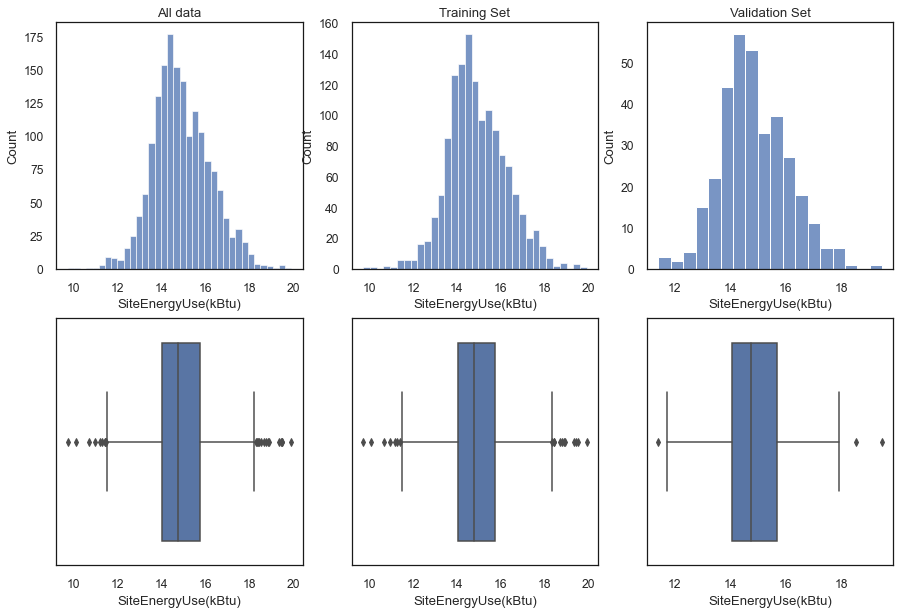

In [36]:
# Comparaison distribution variable cible
fig, ax = plt.subplots(2,3, figsize=(15, 10))
sns.histplot(np.log(y), ax=ax[0,0]).set(title='All data')
sns.histplot(np.log(y_train), ax=ax[0,1]).set(title='Training Set')
sns.histplot(np.log(y_test), ax=ax[0,2]).set(title='Validation Set')
sns.boxplot(x=np.log(y), ax=ax[1,0])
sns.boxplot(x=np.log(y_train), ax=ax[1,1])
sns.boxplot(x=np.log(y_test), ax=ax[1,2])

=> La distribution de la variable a prédire est homogène entre les datasets (entire dataset, train et test sets)

<AxesSubplot:xlabel='ytest_log', ylabel='PrimaryPropertyType_reduced'>

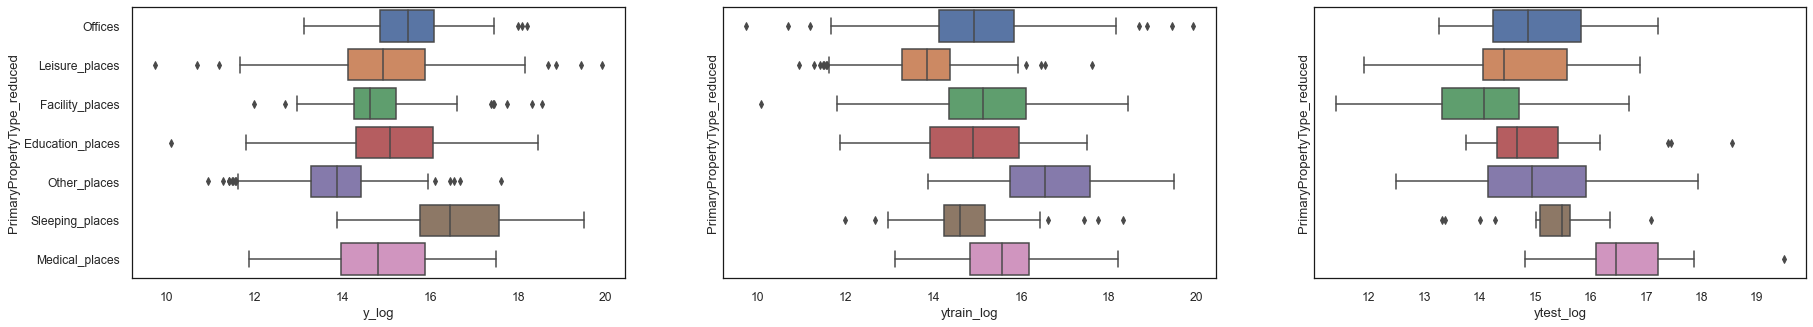

In [37]:
# Comparaison distribution variable cible en fonction des types de batiments
fig, ax = plt.subplots(1,3, figsize=(30,5), sharey=True)
sns.boxplot(x='y_log',y=stratify_var, data=X.assign(y_log=np.log(y)), ax=ax[0])
sns.boxplot(x='ytrain_log', y=stratify_var, data=X_train.assign(ytrain_log=np.log(y_train)),ax=ax[1])
sns.boxplot(x='ytest_log', y=stratify_var, data=X_test.assign(ytest_log=np.log(y_test)),ax=ax[2])

=> Les différents types de batiments sont bien représentés dans les dataset de train et test. 

=> Pour chaque type de bâtiment, les valeurs de la variable à prédire dans le jeu de validation sont majoritairement dans les bornes des valeurs dans le jeu d'entrainement

### Preprocessing

In [38]:
# Preprocessing
num_scaler = RobustScaler()  # Could be StandardScaler() or MinMaxScaler() or RobustScaler() or QuantileTransformer(n_quantiles=)
cat_scaler = OneHotEncoder(sparse=True, handle_unknown="ignore")
transformed_target=True

In [39]:
preprocess_param = {'dataset':dataset, 'target':target_var, 'num_var':num_var, 'cat_var':cat_var, 
                    'target_transformer':transformed_target,'num_processing':num_scaler, 'cat_processing':cat_scaler}

In [40]:
# Préparation des données via pipeline
preprocessing_pipeline = ColumnTransformer([
    ("num", num_scaler, num_var),
    ("cat", cat_scaler, cat_var)
])

## Baseline Models

In [41]:
# Initialisation des listes de modèles et noms de modèles
model_list=[]
model_names_list=[]

In [42]:
# Estimtateurs naïfs
dummy_regr_mean = DummyRegressor(strategy="mean")
model_list.append(dummy_regr_mean)
model_names_list.append('naive_mean')

dummy_regr_med = DummyRegressor(strategy="median")
model_list.append(dummy_regr_med)
model_names_list.append('naive_med')

In [43]:
# Modèles à tester
linreg = Pipeline([
                   ("preprocessor", preprocessing_pipeline),
                   ("model", LinearRegression())
                   ])

model_list.append(linreg)
model_names_list.append('Linear regression')

linregRidge = Pipeline([
                        ("preprocessor", preprocessing_pipeline),
                        ("model", Ridge())
                        ])
model_list.append(linregRidge)
model_names_list.append('Linear regression Ridge')

linregLasso = Pipeline([
                        ("preprocessor", preprocessing_pipeline),
                        ("model", Lasso())
                        ])
model_list.append(linregLasso)
model_names_list.append('Linear regression Lasso')

elasticNet = Pipeline([
                       ("preprocessor", preprocessing_pipeline),
                       ("model", ElasticNet(random_state=0))
                       ])
model_list.append(elasticNet)
model_names_list.append('Elastic net')

svr = Pipeline([
                ("preprocessor", preprocessing_pipeline),
                ("model", LinearSVR(random_state=0))
                ])
model_list.append(svr)
model_names_list.append('SVR')

kernelSVM = Pipeline([
                      ("preprocessor", preprocessing_pipeline),
                      ("model", kernel_ridge.KernelRidge())
                      ])
model_list.append(kernelSVM)
model_names_list.append('KernelRidgeReg')

randomForest = Pipeline([
                         ("preprocessor", preprocessing_pipeline),
                         ("model",RandomForestRegressor(max_depth=2, random_state=0))
                         ])
model_list.append(randomForest)
model_names_list.append('RandomForest')

xgRF = Pipeline([
                 ("preprocessor", preprocessing_pipeline),
                 ("model",xgb.XGBRFRegressor(max_depth=2, random_state=0))
                 ])
model_list.append(xgRF)
model_names_list.append('XGBoost_RF')

xg_reg = Pipeline([
                   ("preprocessor", preprocessing_pipeline),
                   ("model", xgb.XGBRegressor(objective ='reg:squarederror'))
                   ])
model_list.append(xg_reg)
model_names_list.append('XGboost')

lgb_reg = Pipeline([
                    ("preprocessor", preprocessing_pipeline),
                    ("model", lgb.LGBMRegressor())
                    ])
model_list.append(lgb_reg)
model_names_list.append('lightGBM')

In [304]:
# Mise à jour de la table de résultats
for model, model_name in zip(model_list, model_names_list):
    summary = update_summary(summary, preprocess_param, model, model_name, X_train, X_test, y_train, y_test, transformed_target=transformed_target)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,preprocess,Nom_modele,cross_val_nfolds,best_param,r2_train,r2_test,adj_r2_train,adj_r2_test,msle_train,msle_test,explained_var_train,explained_var_test,medAbsError_train,medAbsError_test,mse_train,mse_test,rmse_train,rmse_test,mean_fit_time
0,{'dataset': 'cleaned_data_ManualSel_160222.csv...,naive_mean,NaN,NaN,0.000,-0.003,-0.013,-0.057,2.804,2.635,0.000,-0.000,"6,429,198.994","6,427,951.869","500,387,120,400,106.312","369,177,292,231,036.188","22,369,334.375","19,213,986.891",NaN
1,{'dataset': 'cleaned_data_ManualSel_160222.csv...,naive_med,NaN,NaN,-0.064,-0.056,-0.078,-0.112,1.813,1.537,0.000,0.000,"1,771,870.938","1,651,875.000","532,432,470,422,549.625","388,441,374,055,892.562","23,074,498.270","19,708,916.106",NaN
2,{'dataset': 'cleaned_data_ManualSel_160222.csv...,Linear regression,NaN,NaN,0.651,0.626,0.647,0.606,25.512,31.957,0.659,0.635,"2,103,334.576","2,075,791.300","170,800,673,676,676.875","134,495,611,138,208.703","13,069,073.176","11,597,224.286",NaN
3,{'dataset': 'cleaned_data_ManualSel_160222.csv...,Linear regression Ridge,NaN,NaN,0.284,-0.014,0.274,-0.068,2.005,1.897,0.284,-0.014,"4,013,274.288","3,918,296.949","358,501,968,376,000.062","373,199,032,962,781.750","18,934,148.208","19,318,359.997",NaN
4,{'dataset': 'cleaned_data_ManualSel_160222.csv...,Linear regression Lasso,NaN,NaN,0.795,0.654,0.792,0.636,36.283,42.764,0.803,0.669,"1,776,411.750","1,742,064.636","98,622,567,128,026.969","123,124,651,965,840.047","9,930,889.544","11,096,154.828",NaN
5,{'dataset': 'cleaned_data_ManualSel_160222.csv...,Elastic net,NaN,NaN,0.593,0.663,0.588,0.645,7.536,13.679,0.593,0.664,"1,896,343.949","1,572,201.070","203,473,329,746,106.656","123,737,226,687,915.406","14,264,407.795","11,123,723.598",NaN
6,{'dataset': 'cleaned_data_ManualSel_160222.csv...,SVR,NaN,NaN,0.180,-0.056,0.170,-0.112,27.150,29.017,0.246,0.025,"2,095,249.716","2,071,447.369","410,081,052,835,370.938","388,593,538,013,592.875","20,250,458.090","19,712,776.010",NaN
7,{'dataset': 'cleaned_data_ManualSel_160222.csv...,KernelRidgeReg,NaN,NaN,0.784,0.737,0.781,0.724,35.017,40.754,0.791,0.747,"1,843,211.336","1,676,710.774","104,716,578,917,316.969","93,758,009,203,655.188","10,233,111.888","9,682,871.950",NaN
8,{'dataset': 'cleaned_data_ManualSel_160222.csv...,RandomForest,NaN,NaN,0.682,0.597,0.678,0.575,1.427,1.346,0.682,0.597,"2,929,269.410","2,930,512.057","159,236,523,249,851.156","148,404,400,259,443.375","12,618,895.485","12,182,134.471",NaN
9,{'dataset': 'cleaned_data_ManualSel_160222.csv...,XGBoost_RF,NaN,NaN,0.711,0.573,0.707,0.550,1.464,1.373,0.711,0.573,"2,998,581.875","3,062,934.438","144,649,530,858,488.031","157,191,244,654,394.594","12,027,033.336","12,537,593.256",NaN


In [305]:
summary.to_csv(baseline_summary_name)

### Comparaison des modèles par défaut

In [44]:
summary = pd.read_csv(baseline_summary_name, index_col=0)

In [45]:
n_model = len(model_list)

#### Score R²

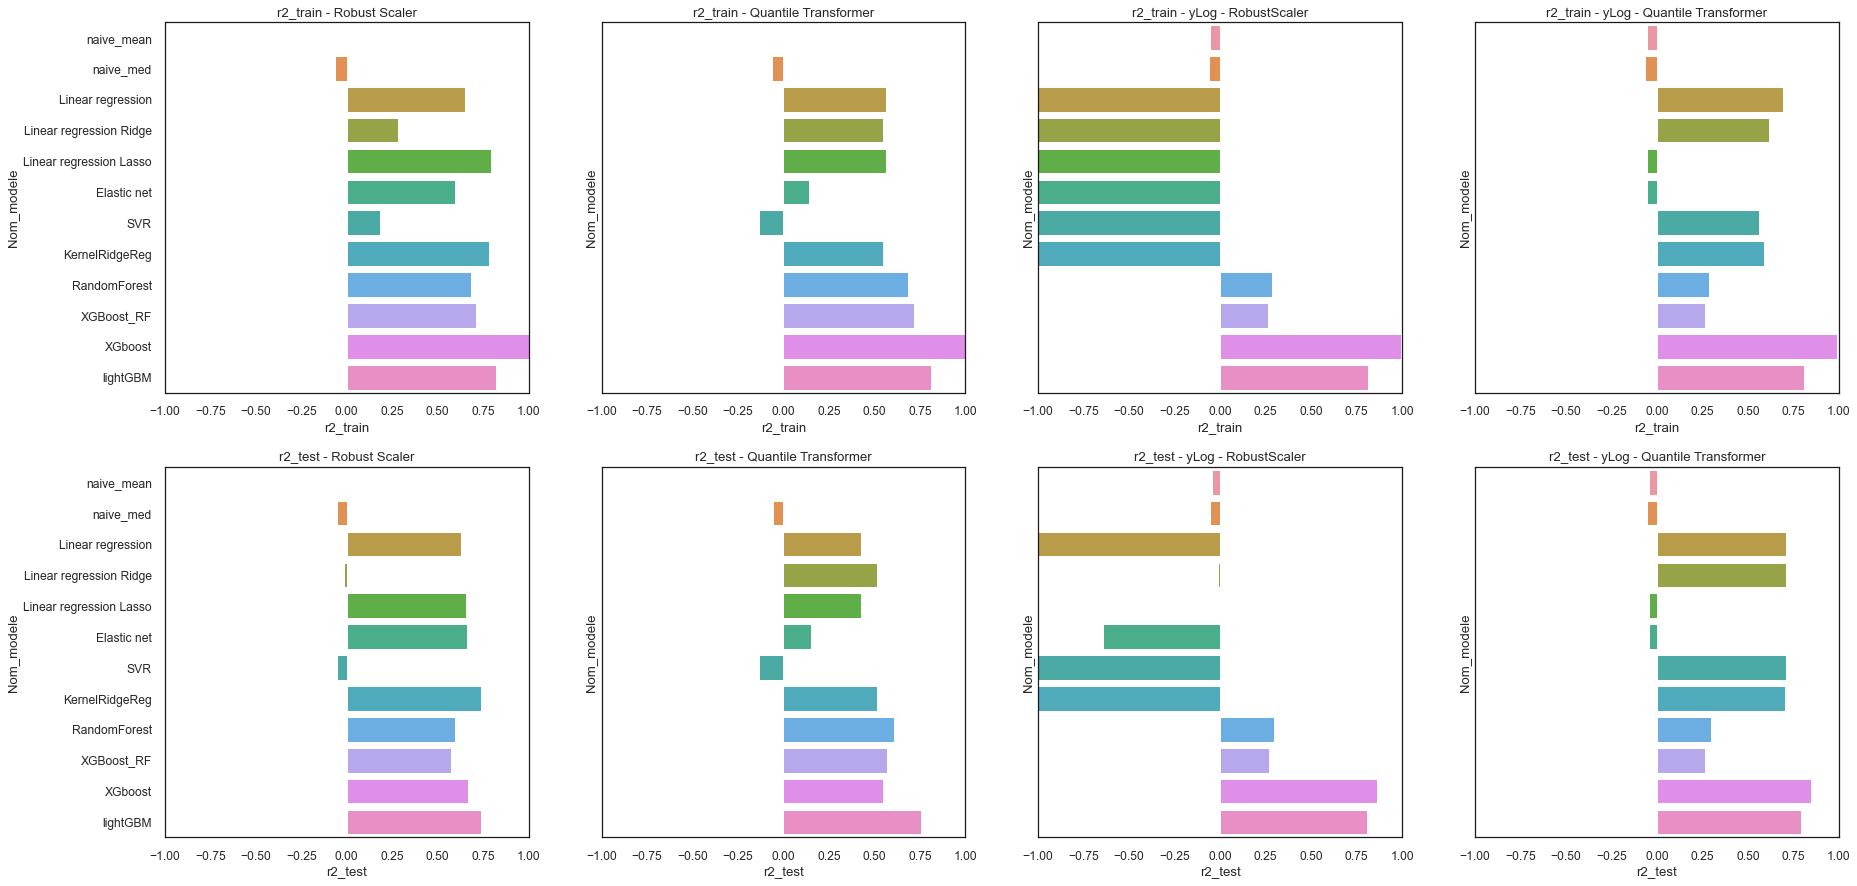

In [46]:
fig, ax = plt.subplots(2,4, figsize=(30,15), sharey=True)
sns.barplot(x='r2_train', y='Nom_modele', data=summary.loc[:n_model-1], ax=ax[0,0])
sns.barplot(x='r2_train', y='Nom_modele', data=summary.loc[n_model:2*n_model-1], ax=ax[0,1])
sns.barplot(x='r2_train', y='Nom_modele', data=summary.loc[2*n_model:3*n_model-1], ax=ax[0,2])
sns.barplot(x='r2_train', y='Nom_modele', data=summary.loc[3*n_model:], ax=ax[0,3])
ax[0,0].set_title('r2_train - Robust Scaler')
ax[0,1].set_title('r2_train - Quantile Transformer')
ax[0,2].set_title('r2_train - yLog - RobustScaler')
ax[0,3].set_title('r2_train - yLog - Quantile Transformer')
ax[0,0].set_xlim(-1, 1)
ax[0,1].set_xlim(-1, 1)
ax[0,2].set_xlim(-1, 1)
ax[0,3].set_xlim(-1, 1)

sns.barplot(x='r2_test', y='Nom_modele', data=summary.loc[:n_model-1], ax=ax[1,0])
sns.barplot(x='r2_test', y='Nom_modele', data=summary.loc[n_model:2*n_model-1], ax=ax[1,1])
sns.barplot(x='r2_test', y='Nom_modele', data=summary.loc[2*n_model:3*n_model-1], ax=ax[1,2])
sns.barplot(x='r2_test', y='Nom_modele', data=summary.loc[3*n_model:], ax=ax[1,3])
ax[1,0].set_title('r2_test - Robust Scaler')
ax[1,1].set_title('r2_test - Quantile Transformer')
ax[1,2].set_title('r2_test - yLog - RobustScaler')
ax[1,3].set_title('r2_test - yLog - Quantile Transformer')
ax[1,0].set_xlim(-1, 1)
ax[1,1].set_xlim(-1, 1)
ax[1,2].set_xlim(-1, 1)
ax[1,3].set_xlim(-1, 1)

plt.savefig('figures/preprocess_choice_R2.png', bbox_inches='tight', dpi=600)

#### Score R² ajusté

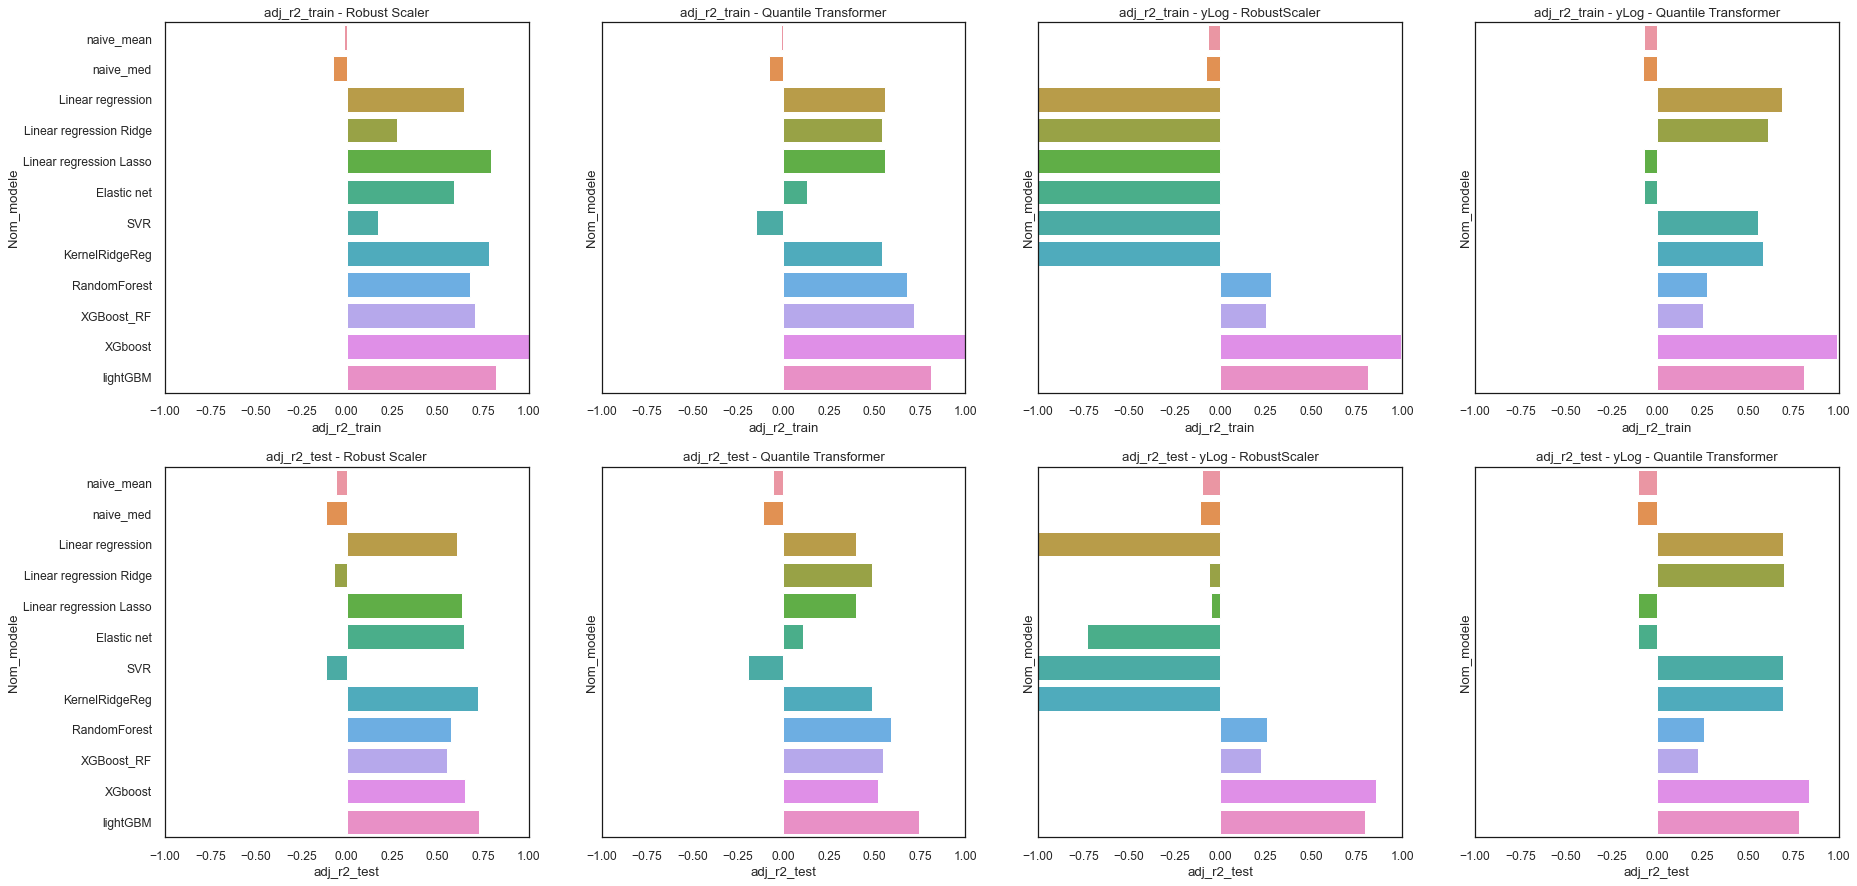

In [47]:
fig, ax = plt.subplots(2,4, figsize=(30,15), sharey=True)
sns.barplot(x='adj_r2_train', y='Nom_modele', data=summary.loc[:n_model-1], ax=ax[0,0])
sns.barplot(x='adj_r2_train', y='Nom_modele', data=summary.loc[n_model:2*n_model-1], ax=ax[0,1])
sns.barplot(x='adj_r2_train', y='Nom_modele', data=summary.loc[2*n_model:3*n_model-1], ax=ax[0,2])
sns.barplot(x='adj_r2_train', y='Nom_modele', data=summary.loc[3*n_model:], ax=ax[0,3])
ax[0,0].set_title('adj_r2_train - Robust Scaler')
ax[0,1].set_title('adj_r2_train - Quantile Transformer')
ax[0,2].set_title('adj_r2_train - yLog - RobustScaler')
ax[0,3].set_title('adj_r2_train - yLog - Quantile Transformer')
ax[0,0].set_xlim(-1, 1)
ax[0,1].set_xlim(-1, 1)
ax[0,2].set_xlim(-1, 1)
ax[0,3].set_xlim(-1, 1)

sns.barplot(x='adj_r2_test', y='Nom_modele', data=summary.loc[:n_model-1], ax=ax[1,0])
sns.barplot(x='adj_r2_test', y='Nom_modele', data=summary.loc[n_model:2*n_model-1], ax=ax[1,1])
sns.barplot(x='adj_r2_test', y='Nom_modele', data=summary.loc[2*n_model:3*n_model-1], ax=ax[1,2])
sns.barplot(x='adj_r2_test', y='Nom_modele', data=summary.loc[3*n_model:], ax=ax[1,3])
ax[1,0].set_title('adj_r2_test - Robust Scaler')
ax[1,1].set_title('adj_r2_test - Quantile Transformer')
ax[1,2].set_title('adj_r2_test - yLog - RobustScaler')
ax[1,3].set_title('adj_r2_test - yLog - Quantile Transformer')
ax[1,0].set_xlim(-1, 1)
ax[1,1].set_xlim(-1, 1)
ax[1,2].set_xlim(-1, 1)
ax[1,3].set_xlim(-1, 1)

plt.savefig('figures/preprocess_choice_adjR2.png', bbox_inches='tight', dpi=600)

In [48]:
best_preprocess = dict(summary.loc[summary.loc[:,'adj_r2_test']==summary.loc[:,'adj_r2_test'].max(), 'preprocess'])
best_preprocess

{34: "{'dataset': 'cleaned_data_ManualSel_160222.csv', 'target': 'SiteEnergyUse(kBtu)', 'num_var': ['BuildingAge', 'NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'], 'cat_var': ['BuildingType', 'PrimaryPropertyType_reduced', 'CouncilDistrictCode', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'], 'target_transformer': True, 'num_processing': RobustScaler(), 'cat_processing': OneHotEncoder(handle_unknown='ignore')}"}

In [49]:
summary.loc[summary.loc[:,'adj_r2_test']==summary.loc[:,'adj_r2_test'].max()]

,preprocess,Nom_modele,cross_val_nfolds,best_param,r2_train,r2_test,adj_r2_train,adj_r2_test,msle_train,msle_test,explained_var_train,explained_var_test,medAbsError_train,medAbsError_test,mse_train,mse_test,rmse_train,rmse_test,mean_fit_time
34,{'dataset': 'cleaned_data_ManualSel_160222.csv...,XGboost,NaN,NaN,0.993,0.863,0.993,0.856,0.031,0.428,0.993,0.863,"215,610.250","820,947.750","3,487,451,276,243.008","50,399,726,053,706.312","1,867,471.894","7,099,276.446",NaN


**Conclusions:**
- Les modèles ensemblistes apparaissent clairement comme les meilleurs modèles. Ce sont donc les modèles que nous allons optimiser. 
- Au vu des résultats, nous choissisons le RobustScaler et de transformer la variable cible en log

## Parameter tuning

In [44]:
# Preprocessing
num_scaler = RobustScaler()  
cat_scaler = OneHotEncoder(sparse=True, handle_unknown="ignore")
transformed_target=True

In [45]:
preprocess_param = {'dataset':dataset, 'target':target_var, 'num_var':num_var, 'cat_var':cat_var, 
                    'target_transformer':transformed_target,'num_processing':num_scaler, 'cat_processing':cat_scaler}

In [46]:
# Préparation des données via pipeline
preprocessing_pipeline = ColumnTransformer([
    ("num", num_scaler, num_var),
    ("cat", cat_scaler, cat_var)
])

In [47]:
# Paramètres communs de tuning des hyperparamètres
scoring_estimates = {'r2':'r2', 'adj_r2': adj_r2, 
                        'neg_mean_squared_error':'neg_mean_squared_error', 
                        'neg_median_absolute_error':'neg_median_absolute_error',
                        'neg_mean_squared_log_error':'neg_mean_squared_log_error', 
                        'neg_root_mean_squared_error':'neg_root_mean_squared_error', 
                        'explained_variance':'explained_variance'}

fit_params = {'transformed_target':transformed_target, 
              'cv':5, 
              'scoring':scoring_estimates, 
              'refit':'adj_r2' , 
              'return_train_score':True, 
              'n_jobs':-1}

In [48]:
# Vérification des variables quantitatives prises en compte
num_var

['BuildingAge',
 'NumberofBuildings',
 'NumberofFloors',
 'ENERGYSTARScore',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA']

In [49]:
# Vérification des variables qualitatives prises en compte
cat_var

['BuildingType',
 'PrimaryPropertyType_reduced',
 'CouncilDistrictCode',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType']

### XG boost RF

In [50]:
# Nom des parametres
xgRF.named_steps['model'].get_params()

{'colsample_bynode': 0.8,
 'learning_rate': 1.0,
 'reg_lambda': 1e-05,
 'subsample': 0.8,
 'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'max_delta_step': None,
 'max_depth': 2,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 0,
 'reg_alpha': None,
 'scale_pos_weight': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [52]:
# Grille de parametres à explorer
grid_params_xgRF_V1 = {
    'regressor__model__colsample_bytree': np.arange(0, 1, 0.2), 
    'regressor__model__learning_rate': np.arange(0, 1, 0.2), 
    'regressor__model__subsample': np.arange(0, 1, 0.2),
    'regressor__model__max_depth': [1, 2, 3], 
    'regressor__model__n_estimators': [100, 200, 300]}
summaryGridSearchCV = run_hyperparameter_tuning(xgRF, grid_params_xgRF_V1, 'xgRF_Opt_V1', preprocess_param, summaryGridSearchCV, X_train, y_train, **fit_params)
summaryGridSearchCV.to_csv(gridSearch_summary_name)

{'regressor__model__colsample_bytree': 0.8, 'regressor__model__learning_rate': 0.8, 'regressor__model__max_depth': 3, 'regressor__model__n_estimators': 100, 'regressor__model__subsample': 0.8}


In [54]:
grid_params_xgRF_V2 = {
    'regressor__model__booster':['gbtree'],
    'regressor__model__colsample_bytree': [0.7, 0.8, 0.9, 1],
    'regressor__model__colsample_bynode': np.arange(0, 1, 0.2),
    'regressor__model__learning_rate': [1], 
    'regressor__model__subsample': [0.7, 0.8, 0.9, 1],
    'regressor__model__max_depth': [1, 3, 6], 
    'regressor__model__n_estimators': [100, 200, 300]}
#cf : https://xgboost.readthedocs.io/en/stable/tutorials/rf.html

summaryGridSearchCV = run_hyperparameter_tuning(xgRF, grid_params_xgRF_V2, 'xgRF_Opt_V2', preprocess_param, summaryGridSearchCV, X_train, y_train, **fit_params)
summaryGridSearchCV.to_csv(gridSearch_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bynode': 0.6000000000000001, 'regressor__model__colsample_bytree': 0.8, 'regressor__model__learning_rate': 1, 'regressor__model__max_depth': 6, 'regressor__model__n_estimators': 300, 'regressor__model__subsample': 1}


In [56]:
grid_params_xgRF_V3 = {
    'regressor__model__booster':['gbtree'],
    'regressor__model__colsample_bytree': [0.7, 0.8, 0.9,1],
    'regressor__model__colsample_bynode': [0.3, 0.4, 0.5],
    'regressor__model__learning_rate': [1], 
    'regressor__model__subsample': [0.7, 0.8, 0.9, 1],
    'regressor__model__max_depth': [1, 3, 6, 8], 
    'regressor__model__n_estimators': [200, 300,400]}

summaryGridSearchCV = run_hyperparameter_tuning(xgRF, grid_params_xgRF_V3, 'xgRF_Opt_V3', preprocess_param, summaryGridSearchCV, X_train, y_train, **fit_params)
summaryGridSearchCV.to_csv(gridSearch_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bynode': 0.4, 'regressor__model__colsample_bytree': 0.9, 'regressor__model__learning_rate': 1, 'regressor__model__max_depth': 8, 'regressor__model__n_estimators': 200, 'regressor__model__subsample': 1}


**Bilan Forêts aléatoires:**
 - Pas d'amélioration notable de la capacité de prédiction des méthodes de forêts aléatoires. 
 - Je décide d'arrêter là l'optimisation et de me concentrer sur les modèles ensemblistes qui apparaissaient, avec leurs valeurs par défaut, comme étant les modèles les plus performants. 

### XGboost

In [57]:
xg_reg.named_steps['model'].get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [58]:
# Grille de parametres à explorer
grid_params_xgboost_V1 = {'regressor__model__booster': ['gbtree', 'gblinear'],
                          'regressor__model__learning_rate':[0.01, 0.1, 1], 
                          'regressor__model__max_depth': [1, 3, 6],
                          'regressor__model__subsample': [0.5, 0.75, 1],
                          'regressor__model__colsample_bytree': [0.5, 0.75, 1],
                          'regressor__model__n_estimators': [50, 100, 200]}

In [59]:
# Parameter tuning
summaryGridSearchCV = run_hyperparameter_tuning(xg_reg, grid_params_xgboost_V1, 'xgboost_Opt_V1', preprocess_param, summaryGridSearchCV, X_train, y_train, **fit_params)
summaryGridSearchCV.to_csv(gridSearch_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 1, 'regressor__model__learning_rate': 0.1, 'regressor__model__max_depth': 6, 'regressor__model__n_estimators': 200, 'regressor__model__subsample': 1}


In [61]:
grid_params_xgboost_V2 = {'regressor__model__booster': ['gbtree'],
                          'regressor__model__learning_rate':[0.3, 0.5, 0.7, 0.9], 
                          'regressor__model__max_depth': [3, 6, 10], 
                          'regressor__model__subsample': [0.7, 0.8, 0.9],
                          'regressor__model__colsample_bytree': [0.3, 0.5, 0.7],
                          'regressor__model__n_estimators': [200, 500, 1000]}

summaryGridSearchCV = run_hyperparameter_tuning(xg_reg, grid_params_xgboost_V2, 'xgboost_Opt_V2', preprocess_param, summaryGridSearchCV, X_train, y_train, **fit_params)
summaryGridSearchCV.to_csv(gridSearch_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.3, 'regressor__model__learning_rate': 0.3, 'regressor__model__max_depth': 3, 'regressor__model__n_estimators': 500, 'regressor__model__subsample': 0.8}


In [64]:
grid_params_xgboost_V3 = {'regressor__model__booster': ['gbtree'],
                          'regressor__model__learning_rate':np.arange(0.1, 1, 0.1), 
                          'regressor__model__max_depth': [1, 2, 3, 6],
                          'regressor__model__subsample': np.arange(0.4, 1, 0.1),
                          'regressor__model__colsample_bytree': np.arange(0.4, 1, 0.1),
                          'regressor__model__n_estimators': np.arange(100, 700, 100)}

summaryGridSearchCV = run_hyperparameter_tuning(xg_reg, grid_params_xgboost_V3, 'xgboost_Opt_V3', preprocess_param, summaryGridSearchCV, X_train, y_train, **fit_params)
summaryGridSearchCV.to_csv(gridSearch_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.7, 'regressor__model__learning_rate': 0.30000000000000004, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 600, 'regressor__model__subsample': 0.8999999999999999}


In [66]:
grid_params_xgboost_V4 = {'regressor__model__booster': ['gbtree'],
                          'regressor__model__learning_rate':[0.1, 0.2, 0.3], 
                          'regressor__model__max_depth': [1, 2, 3, 6],
                          'regressor__model__subsample': np.arange(0.2, 1, 0.1),
                          'regressor__model__colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7],
                          'regressor__model__n_estimators': np.arange(200, 1500, 100)}

summaryGridSearchCV = run_hyperparameter_tuning(xg_reg, grid_params_xgboost_V4, 'xgboost_Opt_V4', preprocess_param, summaryGridSearchCV, X_train, y_train, **fit_params)
summaryGridSearchCV.to_csv(gridSearch_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.7, 'regressor__model__learning_rate': 0.3, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 600, 'regressor__model__subsample': 0.9000000000000001}


In [68]:
grid_params_xgboost_V5 = {'regressor__model__booster': ['gbtree'],
                          'regressor__model__learning_rate':[0.15, 0.2, 0.25], 
                          'regressor__model__max_depth': [1, 2, 3, 6],
                          'regressor__model__subsample': [0.35, 0.4, 0.45],
                          'regressor__model__colsample_bytree': [0.55, 0.6, 0.65],
                          'regressor__model__n_estimators': [300, 500, 700]}

summaryGridSearchCV = run_hyperparameter_tuning(xg_reg, grid_params_xgboost_V5, 'xgboost_Opt_V5', preprocess_param, summaryGridSearchCV, X_train, y_train, **fit_params)
summaryGridSearchCV.to_csv(gridSearch_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.6, 'regressor__model__learning_rate': 0.25, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 500, 'regressor__model__subsample': 0.45}


In [69]:
summaryGridSearchCV

,preprocess,Nom_modele,cross_val_nfolds,best_param,r2_train,r2_test,adj_r2_train,adj_r2_test,msle_train,msle_test,explained_var_train,explained_var_test,medAbsError_train,medAbsError_test,mse_train,mse_test,rmse_train,rmse_test,mean_fit_time
0,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgRF_Opt_V1,5,"{'regressor__model__colsample_bytree': 0.8, 'r...",-0.110,-0.125,-0.127,-0.200,8.977,9.053,0.019,0.020,"2,437,648.244","2,416,382.788","554,546,868,252,331.812","555,530,013,742,331.000","23,506,446.453","23,034,117.577",0.499
1,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgRF_Opt_V2,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.937,0.503,0.936,0.470,0.329,0.522,0.940,0.511,"726,332.267","849,543.052","31,195,724,475,354.520","270,232,635,362,489.844","5,582,764.248","15,352,309.839",3.451
2,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgRF_Opt_V3,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.978,0.524,0.978,0.492,0.213,0.478,0.979,0.532,"579,268.338","844,089.819","10,916,078,813,314.229","257,656,930,703,676.156","3,298,670.823","15,031,738.601",3.847
3,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_V1,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.979,0.733,0.979,0.715,0.057,0.393,0.980,0.736,"302,817.025","750,526.281","10,087,877,401,964.070","159,500,945,386,751.250","3,157,776.186","11,456,722.385",2.944
4,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_V2,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.994,0.762,0.994,0.745,0.017,0.432,0.994,0.764,"187,944.450","823,055.878","3,011,359,355,991.531","149,822,300,730,191.875","1,725,458.624","10,821,808.275",1.565
5,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_V3,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.981,0.830,0.981,0.819,0.059,0.414,0.981,0.832,"330,835.219","860,247.225","9,261,884,771,348.359","90,653,877,224,039.500","3,030,134.775","9,050,772.365",2.961
6,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_V4,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.981,0.830,0.981,0.819,0.059,0.414,0.981,0.832,"330,835.219","860,247.225","9,261,884,771,348.359","90,653,877,224,039.500","3,030,134.775","9,050,772.365",2.688
7,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_V5,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.948,0.783,0.947,0.768,0.099,0.438,0.949,0.784,"438,500.300","824,776.950","24,512,857,661,680.352","124,093,383,822,341.578","4,898,107.620","10,266,181.163",3.400


**Bilan :**
  - Je n'arrive plus à améliorer les performances de l'algorithme XGBoost sans risquer d'augmenter le sur-apprentissage.
  - Je décide d'arrêter là l'optimisation de cet algorithme et de voir si le lightGBM fait mieux

### LightGBM

In [70]:
lgb_reg.named_steps['model'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [71]:
# Grille de parametres à explorer
grid_params_lgbm_V1 = {'regressor__model__learning_rate':[0.5, 0.7, 0.9], 
                       'regressor__model__max_depth': [-1, 1, 3, 6, 10],
                       'regressor__model__subsample': [0.5, 0.7, 0.9],
                       'regressor__model__colsample_bytree': [0.5, 0.7, 0.9],
                       'regressor__model__n_estimators': [100,200,500],
                       'regressor__model__num_leaves': [7, 15, 31, 63]}

In [72]:
# Run model
summaryGridSearchCV = run_hyperparameter_tuning(lgb_reg, grid_params_lgbm_V1, 'lightGBM_Opt_V1', preprocess_param, summaryGridSearchCV, X_train, y_train, **fit_params)
summaryGridSearchCV.to_csv(gridSearch_summary_name)

{'regressor__model__colsample_bytree': 0.7, 'regressor__model__learning_rate': 0.5, 'regressor__model__max_depth': 1, 'regressor__model__n_estimators': 100, 'regressor__model__num_leaves': 7, 'regressor__model__subsample': 0.5}


In [74]:
grid_params_lgbm_V2 = {'regressor__model__learning_rate':[0.8, 0.9, 1], 
                       'regressor__model__max_depth': [1, 2, 3, 6],
                       'regressor__model__subsample': [0.4, 0.5, 0.6],
                       'regressor__model__colsample_bytree': [0.4, 0.6, 0.7, 0.8],
                       'regressor__model__n_estimators': [300,500,1000],
                       'regressor__model__num_leaves': [3, 7, 15, 31]}

summaryGridSearchCV = run_hyperparameter_tuning(lgb_reg, grid_params_lgbm_V2, 'lightGBM_Opt_V2', preprocess_param, summaryGridSearchCV, X_train, y_train, **fit_params)
summaryGridSearchCV.to_csv(gridSearch_summary_name)

{'regressor__model__colsample_bytree': 0.4, 'regressor__model__learning_rate': 1, 'regressor__model__max_depth': 1, 'regressor__model__n_estimators': 1000, 'regressor__model__num_leaves': 3, 'regressor__model__subsample': 0.4}


In [76]:
grid_params_lgbm_V3 = {'regressor__model__learning_rate':[0.8, 0.9, 1], 
                       'regressor__model__max_depth': [1, 2, 3, 4],
                       'regressor__model__subsample': [0.3, 0.4, 0.5],
                       'regressor__model__colsample_bytree': [0.5, 0.6, 0.7],
                       'regressor__model__n_estimators': [400,500,600],
                       'regressor__model__num_leaves': [3, 7, 15]}

summaryGridSearchCV = run_hyperparameter_tuning(lgb_reg, grid_params_lgbm_V3, 'lightGBM_Opt_V3', preprocess_param, summaryGridSearchCV, X_train, y_train, **fit_params)
summaryGridSearchCV.to_csv(gridSearch_summary_name)

{'regressor__model__colsample_bytree': 0.5, 'regressor__model__learning_rate': 1, 'regressor__model__max_depth': 1, 'regressor__model__n_estimators': 500, 'regressor__model__num_leaves': 3, 'regressor__model__subsample': 0.3}


In [78]:
grid_params_lgbm_V4 = {'regressor__model__learning_rate':[0.85, 0.9, 0.95], 
                       'regressor__model__max_depth': [1, 5, 7, 9],
                       'regressor__model__subsample': [0.2, 0.3, 0.4],
                       'regressor__model__colsample_bytree': [0.55, 0.6, 0.65],
                       'regressor__model__n_estimators': [500,600,700],
                       'regressor__model__num_leaves': [3, 7, 15, 31]}

summaryGridSearchCV = run_hyperparameter_tuning(lgb_reg, grid_params_lgbm_V4, 'lightGBM_Opt_V4', preprocess_param, summaryGridSearchCV, X_train, y_train, **fit_params)
summaryGridSearchCV.to_csv(gridSearch_summary_name)

{'regressor__model__colsample_bytree': 0.55, 'regressor__model__learning_rate': 0.9, 'regressor__model__max_depth': 1, 'regressor__model__n_estimators': 700, 'regressor__model__num_leaves': 3, 'regressor__model__subsample': 0.2}


In [79]:
summaryGridSearchCV

,preprocess,Nom_modele,cross_val_nfolds,best_param,r2_train,r2_test,adj_r2_train,adj_r2_test,msle_train,msle_test,explained_var_train,explained_var_test,medAbsError_train,medAbsError_test,mse_train,mse_test,rmse_train,rmse_test,mean_fit_time
0,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgRF_Opt_V1,5,"{'regressor__model__colsample_bytree': 0.8, 'r...",-0.110,-0.125,-0.127,-0.200,8.977,9.053,0.019,0.020,"2,437,648.244","2,416,382.788","554,546,868,252,331.812","555,530,013,742,331.000","23,506,446.453","23,034,117.577",0.499
1,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgRF_Opt_V2,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.937,0.503,0.936,0.470,0.329,0.522,0.940,0.511,"726,332.267","849,543.052","31,195,724,475,354.520","270,232,635,362,489.844","5,582,764.248","15,352,309.839",3.451
2,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgRF_Opt_V3,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.978,0.524,0.978,0.492,0.213,0.478,0.979,0.532,"579,268.338","844,089.819","10,916,078,813,314.229","257,656,930,703,676.156","3,298,670.823","15,031,738.601",3.847
3,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_V1,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.979,0.733,0.979,0.715,0.057,0.393,0.980,0.736,"302,817.025","750,526.281","10,087,877,401,964.070","159,500,945,386,751.250","3,157,776.186","11,456,722.385",2.944
4,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_V2,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.994,0.762,0.994,0.745,0.017,0.432,0.994,0.764,"187,944.450","823,055.878","3,011,359,355,991.531","149,822,300,730,191.875","1,725,458.624","10,821,808.275",1.565
5,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_V3,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.981,0.830,0.981,0.819,0.059,0.414,0.981,0.832,"330,835.219","860,247.225","9,261,884,771,348.359","90,653,877,224,039.500","3,030,134.775","9,050,772.365",2.961
6,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_V4,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.981,0.830,0.981,0.819,0.059,0.414,0.981,0.832,"330,835.219","860,247.225","9,261,884,771,348.359","90,653,877,224,039.500","3,030,134.775","9,050,772.365",2.688
7,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_V5,5,"{'regressor__model__booster': 'gbtree', 'regre...",0.948,0.783,0.947,0.768,0.099,0.438,0.949,0.784,"438,500.300","824,776.950","24,512,857,661,680.352","124,093,383,822,341.578","4,898,107.620","10,266,181.163",3.400
8,{'dataset': 'cleaned_data_ManualSel_160222.csv...,lightGBM_Opt_V1,5,"{'regressor__model__colsample_bytree': 0.7, 'r...",0.613,0.575,0.607,0.546,0.352,0.439,0.616,0.578,"749,574.099","835,445.718","195,209,241,254,065.188","227,149,710,871,362.562","13,890,482.791","13,873,589.459",0.120
9,{'dataset': 'cleaned_data_ManualSel_160222.csv...,lightGBM_Opt_V2,5,"{'regressor__model__colsample_bytree': 0.4, 'r...",0.831,0.597,0.828,0.570,0.236,0.456,0.832,0.599,"623,655.645","901,285.909","83,728,398,545,205.141","185,431,729,941,334.938","9,132,815.833","13,081,736.597",1.477


**Bilan :**
  - Je n'arrive pas à améliorer suffisamment les performances de l'algorithme LightGBM pour arriver au niveau des performances de XGboost.
  - Je décide d'arrêter là l'optimisation de cet algorithme et de choisir le meilleur modèle obtenu jusqu'ici. 

### Comparaison des modèles

In [50]:
summaryGridSearchCV = pd.read_csv(gridSearch_summary_name, index_col=0)

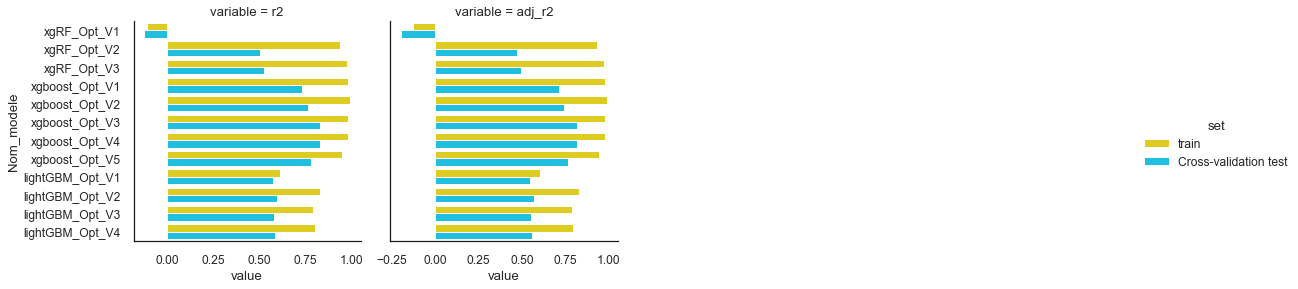

In [51]:
plot_model_comparison(summaryGridSearchCV, model_name_var='Nom_modele', score_list=['r2', 'adj_r2'], savefig='figures/modelComparisonConsoEnergy.png')

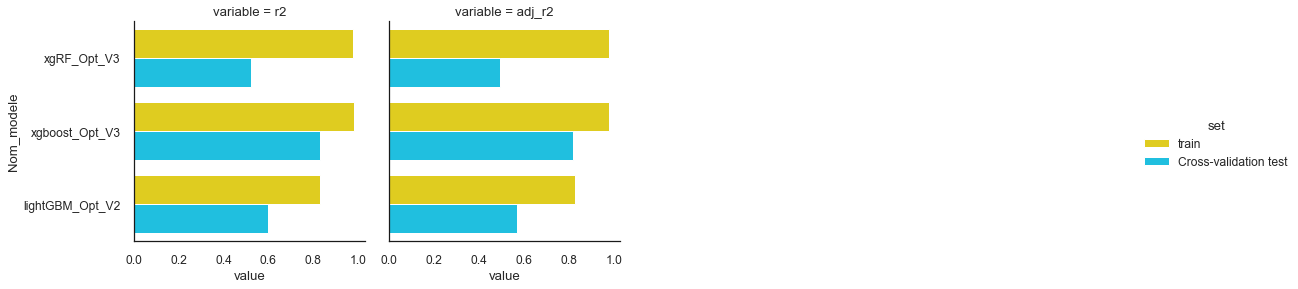

In [52]:
plot_model_comparison(summaryGridSearchCV.loc[[2, 5, 9]], model_name_var='Nom_modele', score_list=['r2', 'adj_r2'], savefig='figures/modelComparisonConsoEnergy_BestofEachAlgo.png')

**Conclusions:**
- Les modèles sont tous en overfitting;
- Sur les jeu d'entrainement, les random forest et gradient boosting par xgboost sont les plus performans (R2 et  adj_r2> 0.8)
- Les forêts aléatoires sont largement en sur-apprentissage
- Les lightGBM font moins bien que les xgBoost sur les jeux d'entrainement et de validation croisée, et sont plus en sur-apprentissage que les xgBoost 
- Le modèle appraissant le plus performant sur le jeu de validation croisée et le moins en overfitting est le modèle **xgBoost_Opt_V3** 
=> Le modèle conservé pour la suite de l'analyse est  **xgBoost_Opt_V3**. 

### Meilleur modèle

In [53]:
best_model = 'xgboost_Opt_V3'
best_param = summaryGridSearchCV.loc[summaryGridSearchCV.loc[:, 'Nom_modele'] == best_model, 'best_param'].values[0]
best_param

"{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.7, 'regressor__model__learning_rate': 0.30000000000000004, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 600, 'regressor__model__subsample': 0.8999999999999999}"

In [54]:
fitted_param_Energy = {'booster': 'gbtree', 'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 2,'n_estimators': 600,'subsample':0.9}

In [55]:
estimator_Energy = xgb.XGBRegressor(objective ='reg:squarederror', **fitted_param_Energy)
pipe_Energy = Pipeline([
                 ("preprocessor", preprocessing_pipeline),
                 ("model", estimator_Energy)
                 ])

In [56]:
final_model_Energy = TransformedTargetRegressor(regressor=pipe_Energy, func=np.log, inverse_func=np.exp)
final_model_Energy.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       RobustScaler(),
                                                                                       ['BuildingAge',
                                                                                        'NumberofBuildings',
                                                                                        'NumberofFloors',
                                                                                        'ENERGYSTARScore',
                                                                                        'PropertyGFATotal',
                                                                                        'PropertyGFAParking',
                                                                                        'PropertyGFABuilding(s)',
                                                                                        'LargestPropertyUseTypeGFA',
                                                                                        'SecondLargestProper...
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.3,
                                                                   max_delta_step=None,
                                                                   max_depth=2,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=600,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=None,
                                                                   reg_alpha=None,
                                                                   reg_lambda=None,
                                                                   scale_pos_weight=None,
                                                                   subsample=0.9,
                                                                   tree_method=None,
                                                                   validate_parameters=None,
                                                                   verbosity=None))]))

## Evaluation du meilleur modèle

In [58]:
cv=5
score=adj_r2 

### Courbe d'apprentissage

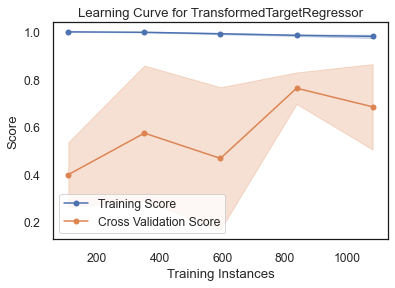

In [59]:
learning_curve = LearningCurve(final_model_Energy, scoring=score, cv=cv)
learning_curve.fit(X_train, y_train)
learning_curve.finalize()
plt.savefig('figures/learning_curve_final_model_Energy.png', bbox_inches='tight', dpi=dpi)

=> La courbe d'apprentissage montre que le **sur-apprentissage diminue avec l'augmentation et du jeu de données**. 

=> Vue la tendance, on peut raisonnablement imaginer que **l'augmentation du jeu de données permettrait de réduire le sur-apprentissage**.

### Courbe de validation

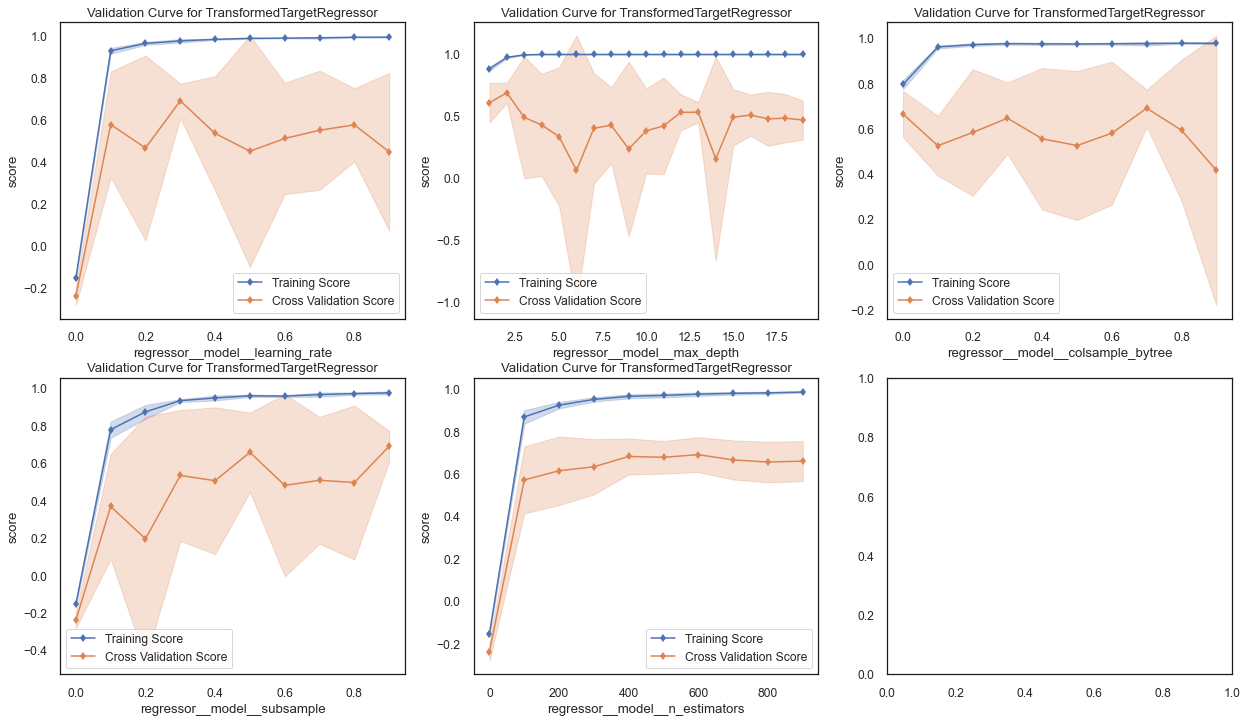

In [70]:
param_list = ["regressor__model__learning_rate", "regressor__model__max_depth", "regressor__model__colsample_bytree", 
              "regressor__model__subsample", "regressor__model__n_estimators"]

param_list_ranges = [np.arange(0,1, 0.1), np.arange(1,20, 1), np.arange(0,1, 0.10), 
                     np.arange(0,1, 0.1), np.arange(0,1000, 100)]

plot_validation_curves(final_model_Energy, param_list, param_list_ranges, X, y, cv=cv, scoring=score, nrows=2, sharey=False)

Les courbes de validation sont en accord avec les hyper-paramètres finaux choisi par GridSearchCV.

### Importance des variables

In [60]:
# Choix du nombre de variables à afficher
n_var = 15

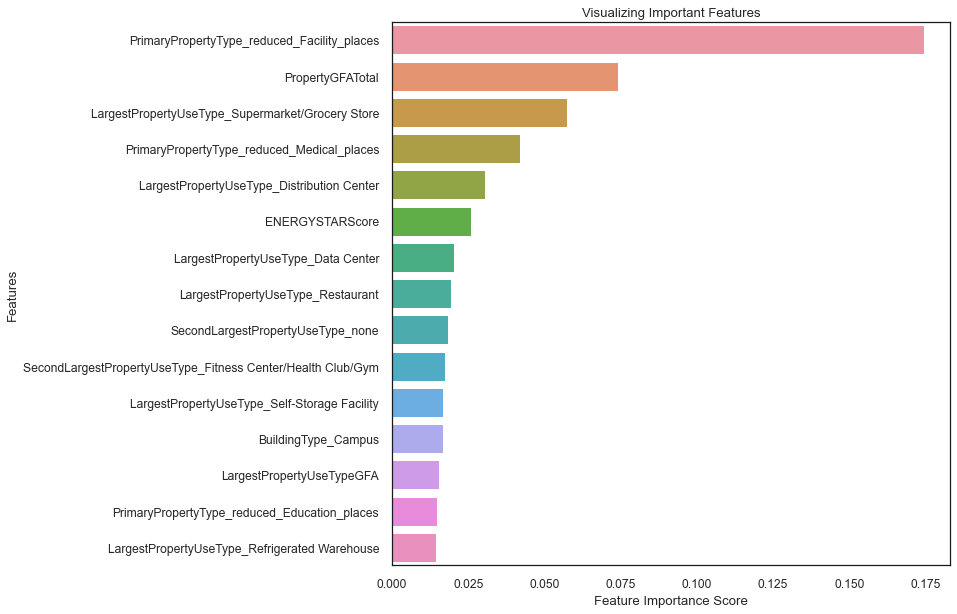

In [61]:
plot_feature_importance(final_model_Energy, n_var, figsize=(10, 10), savefig='figures/SiteEnergyUse_finalModel_feature_importance.png')

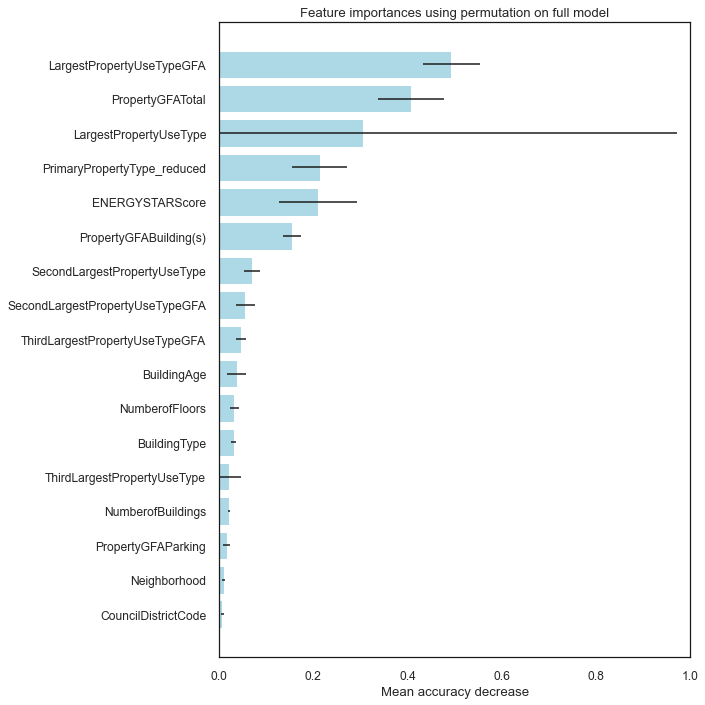

In [62]:
plot_feature_permutation_importance(final_model_Energy, X_train, y_train, scoring='r2', color="lightblue", n_repeats=100, random_state=0, savefig='figures/energy_variablePermutation_trainSet.png')

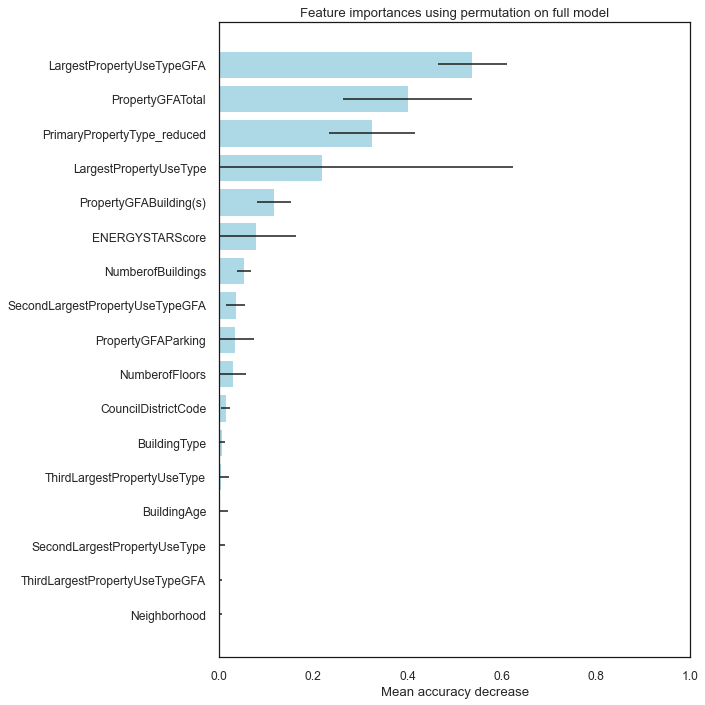

In [63]:
plot_feature_permutation_importance(final_model_Energy, X_test, y_test, scoring='r2', color="lightblue", n_repeats=100, random_state=0, savefig='figures/energy_variablePermutation_testSet.png')

### Valeurs prédites vs. valeurs observées

#### Toutes données

In [64]:
y_test_pred = final_model_Energy.predict(X_test)

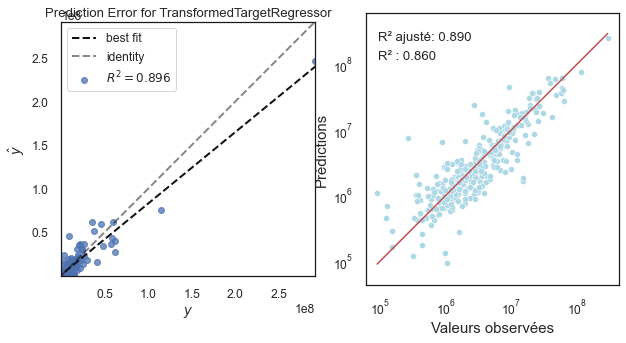

In [65]:
plot_predictions(final_model_Energy, X_train, y_train, X_test, y_test, y_test_pred, color='lightblue', savefig='figures/SiteEnergyUse_finalModel_predictions.png')

#### Détail par type de batiment

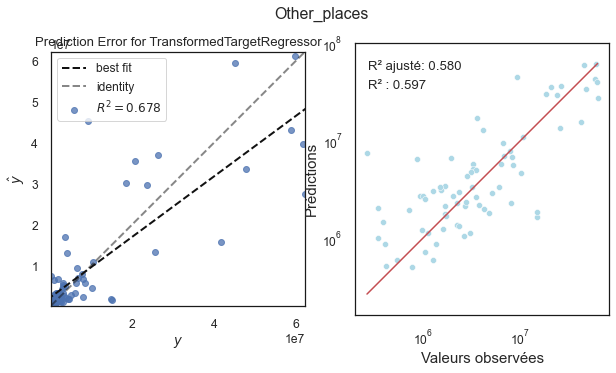

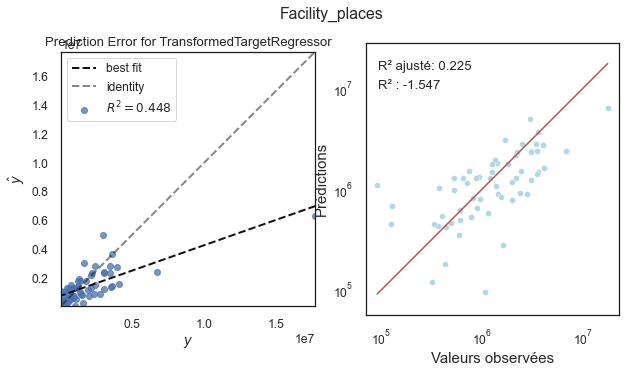

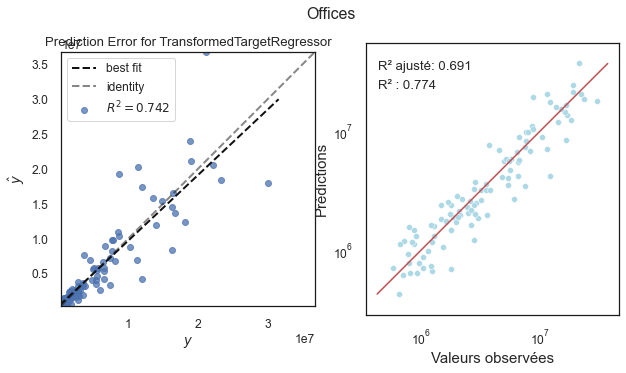

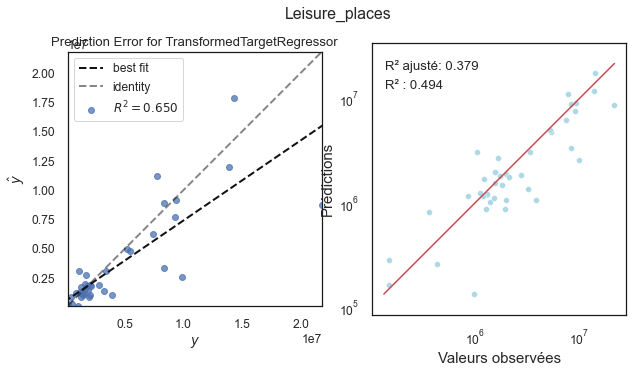

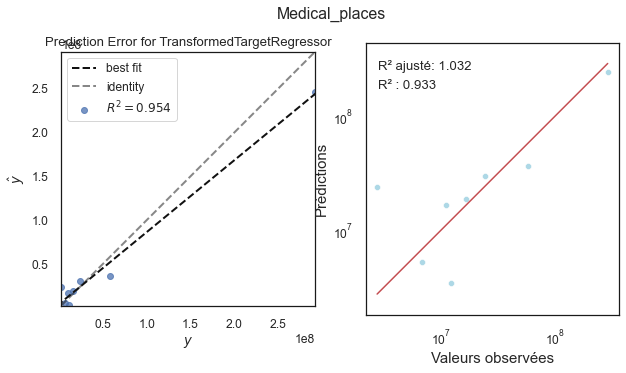

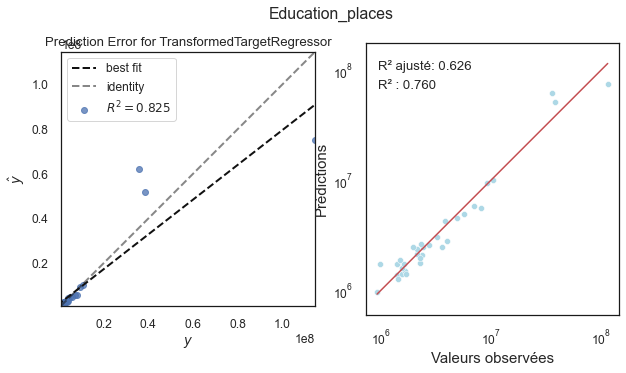

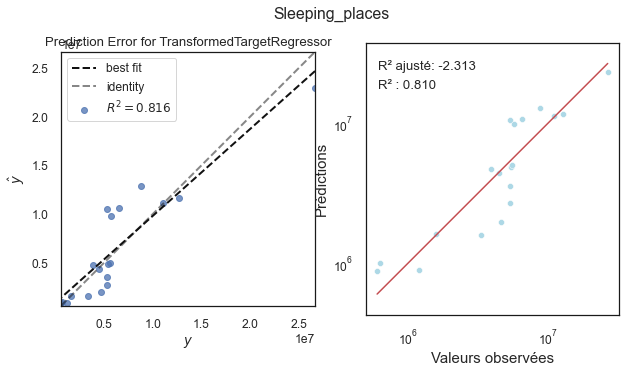

In [74]:
plot_predictions(final_model_Energy, X_train, y_train, X_test, y_test, y_test_pred, hue='PrimaryPropertyType_reduced', color='lightblue', savefig='figures/SiteEnergyUse_finalModel_predictions_byPropertyTypeRed.png')

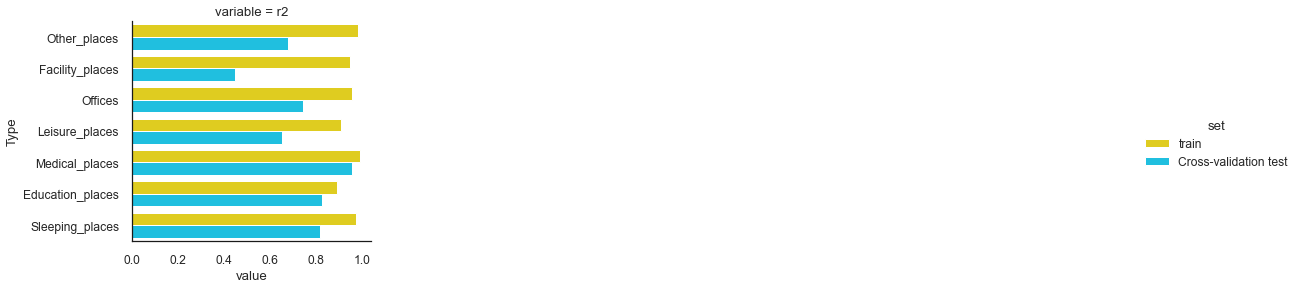

In [66]:
barplot_prediction_Errors(final_model_Energy, X_train, y_train, X_test, y_test, hue='PrimaryPropertyType_reduced', metric='r2', color='lightblue', savefig='figures/SiteEnergyUse_finalModel_predictions_byPropertyTypeRed_R2.png')

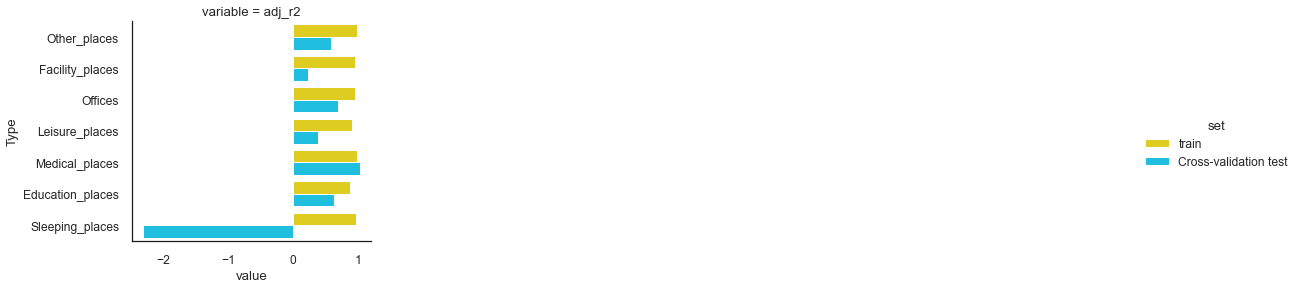

In [67]:
barplot_prediction_Errors(final_model_Energy, X_train, y_train, X_test, y_test, hue='PrimaryPropertyType_reduced', metric='adj_r2', color='lightblue', savefig='figures/SiteEnergyUse_finalModel_predictions_byPropertyTypeRed_adjR2.png')

### Distribution des résidus

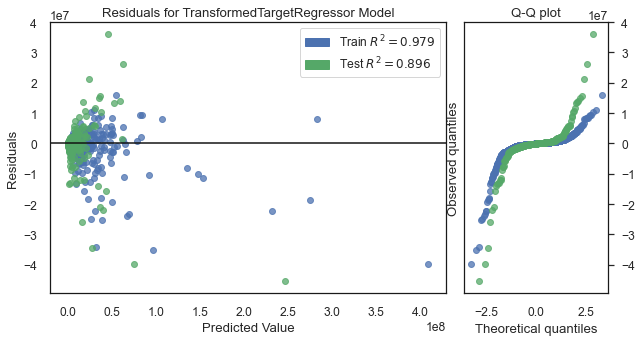

<AxesSubplot:title={'center':'Residuals for TransformedTargetRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [68]:
fig = plt.figure(figsize=(10, 5))
visualizer = ResidualsPlot(final_model_Energy, hist=False, qqplot=True, is_fitted=True)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 

# Partie 3 - Prédiction des emissions de CO² (TotalGHGEmissions)

## Préparation des dataframes de stockage des résultats

In [69]:
# Preparation des dataframe de stockage des résultats
summaryGridSearchCV_GHGE = pd.DataFrame(np.empty(0, dtype=dtypes))

In [70]:
# Nom du résumé à sauver
gridSearch_GHGE_summary_name = "summaryGridSearchCV_GHGE_Tuning_220222_TTR_Robut=stScaler_train08_adjR2_Sklearn_1-0-2_logExp.csv"

## Préparation du modèle

### Choix des variables à utiliser

In [71]:
# Variables à utiliser
target_var = "TotalGHGEmissions"
cat_var = cat_var + ['steam01', 'elec01', 'gas01', 'otherFuels01']

In [72]:
# Vérification des variables qualitatives
cat_var

['BuildingType',
 'PrimaryPropertyType_reduced',
 'CouncilDistrictCode',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'steam01',
 'elec01',
 'gas01',
 'otherFuels01']

In [73]:
# Vérification des variables quantitatives
num_var

['BuildingAge',
 'NumberofBuildings',
 'NumberofFloors',
 'ENERGYSTARScore',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA']

### Création des jeux d'entrainement et de validation

In [74]:
# Set train size
train_size = 0.8
stratify_var = 'PrimaryPropertyType_reduced'

In [75]:
# Creation jeu de test et train
# Creation jeu de test et train
y_GHGE = df.loc[:, target_var]
X_GHGE = df.loc[:, num_var + cat_var]

X_trainGHGE, X_testGHGE, y_trainGHGE, y_testGHGE= train_test_split(X_GHGE, y_GHGE, train_size=train_size, stratify=X_GHGE.loc[:,stratify_var], random_state=100) 

<AxesSubplot:xlabel='TotalGHGEmissions'>

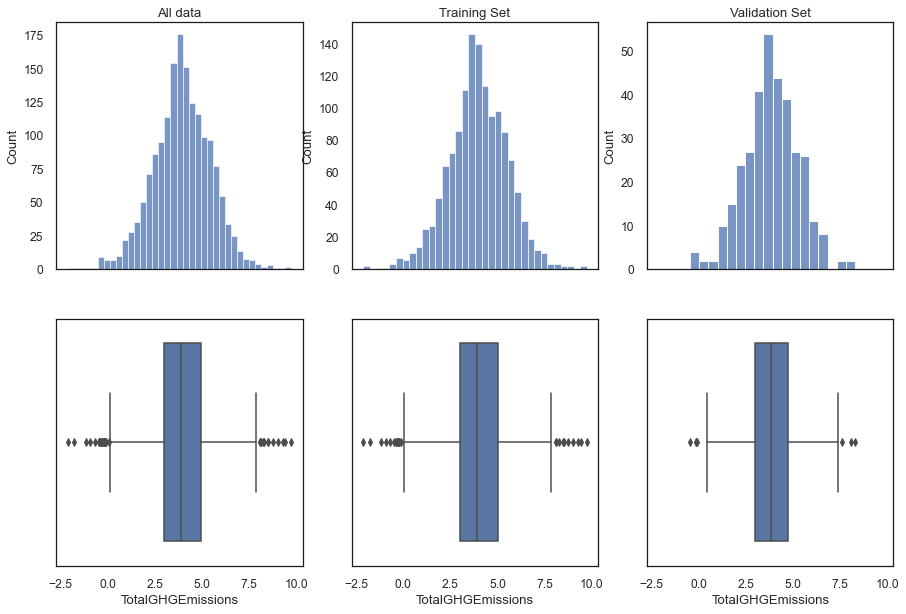

In [76]:
# Comparaison distribution variable cible
fig, ax = plt.subplots(2,3, figsize=(15, 10), sharex=True)
sns.histplot(np.log(y_GHGE), ax=ax[0,0]).set(title='All data')
sns.histplot(np.log(y_trainGHGE), ax=ax[0,1]).set(title='Training Set')
sns.histplot(np.log(y_testGHGE), ax=ax[0,2]).set(title='Validation Set')
sns.boxplot(x=np.log(y_GHGE), ax=ax[1,0])
sns.boxplot(x=np.log(y_trainGHGE), ax=ax[1,1])
sns.boxplot(x=np.log(y_testGHGE), ax=ax[1,2])

=> La distribution de la variable a prédire est homogène entre les datasets (entire dataset, train et test sets)

<AxesSubplot:xlabel='ytest_log', ylabel='PrimaryPropertyType_reduced'>

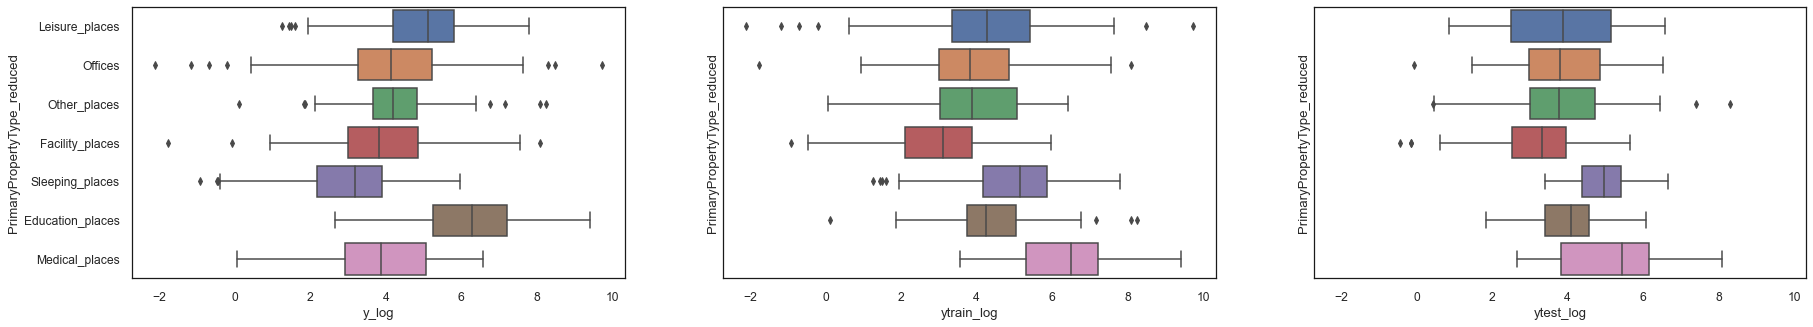

In [77]:
# Comparaison distribution variable cible en fonction des types de batiments
fig, ax = plt.subplots(1,3, figsize=(30,5), sharey=True, sharex=True)
sns.boxplot(x='y_log',y=stratify_var, data=X_GHGE.assign(y_log=np.log(y_GHGE)), ax=ax[0])
sns.boxplot(x='ytrain_log', y=stratify_var, data=X_trainGHGE.assign(ytrain_log=np.log(y_trainGHGE)),ax=ax[1])
sns.boxplot(x='ytest_log', y=stratify_var, data=X_testGHGE.assign(ytest_log=np.log(y_testGHGE)),ax=ax[2])

=> Les différents types de batiments sont bien représentés dans les dataset de train et test. 

=> Pour chaque type de bâtiment, les valeurs de la variable à prédire dans le jeu de validation sont majoritairement dans les bornes des valeurs dans le jeu d'entrainement

### Préprocessing

In [78]:
# Preprocessing
num_scaler = RobustScaler()  # Could be StandardScaler() or MinMaxScaler() or RobustScaler() or QuantileTransformer(n_quantiles=)
cat_scaler = OneHotEncoder(sparse=True, handle_unknown="ignore")
transformed_target=True

In [79]:
preprocess_param = {'dataset':dataset, 'target':target_var, 'num_var':num_var, 'cat_var':cat_var, 
                    'target_transformer':transformed_target,'num_processing':num_scaler, 'cat_processing':cat_scaler}

In [80]:
# Préparation des données via pipeline
preprocessing_pipeline = ColumnTransformer([
    ("num", num_scaler, num_var),
    ("cat", cat_scaler, cat_var)
])

In [81]:
# Pipeline
xg_reg = Pipeline([
                   ("preprocessor", preprocessing_pipeline),
                   ("model", xgb.XGBRegressor(objective ='reg:squarederror'))
                   ])

In [82]:
# SiteEnergyUse model
estimatorEnergy = xgb.XGBRegressor(objective ='reg:squarederror', **fitted_param_Energy)
pipeEnergy = Pipeline([
                 ("preprocessor", preprocessing_pipeline),
                 ("model", estimatorEnergy)
                 ])

In [69]:
#Utilisation telle quelle du modèle de SiteEnergy Use
summaryGridSearchCV_GHGE = update_summary(summaryGridSearchCV_GHGE, preprocess_param, pipeEnergy, 'SiteEnergyUse_Model', X_trainGHGE, X_testGHGE, y_trainGHGE, y_testGHGE, transformed_target=transformed_target)
summaryGridSearchCV_GHGE

,preprocess,Nom_modele,cross_val_nfolds,best_param,r2_train,r2_test,adj_r2_train,adj_r2_test,msle_train,msle_test,explained_var_train,explained_var_test,medAbsError_train,medAbsError_test,mse_train,mse_test,rmse_train,rmse_test,mean_fit_time
0,{'dataset': 'cleaned_data_ManualSel_160222.csv...,SiteEnergyUse_Model,NaN,NaN,0.957,0.730,0.957,0.712,0.111,0.533,0.958,0.730,10.312,20.110,"25,415.899","29,613.928",159.424,172.087,NaN


=> Le modèle "Consommation d'energie" appliqué aux émissions de gaz à effet de serre semble déja relativement bien performant. 

## Optimisation du modèle

In [70]:
pipeGHGE = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("model", xgb.XGBRegressor(objective ='reg:squarederror'))
])

In [71]:
# Paramètres communs de tuning des hyperparamètres
scoring_estimates = {'r2':'r2', 'adj_r2': adj_r2, 
                        'neg_mean_squared_error':'neg_mean_squared_error', 
                        'neg_median_absolute_error':'neg_median_absolute_error',
                        'neg_mean_squared_log_error':'neg_mean_squared_log_error', 
                        'neg_root_mean_squared_error':'neg_root_mean_squared_error', 
                        'explained_variance':'explained_variance'}

fit_params = {'transformed_target':transformed_target, 
              'cv':5, 
              'scoring':scoring_estimates, 
              'refit':'adj_r2' , 
              'return_train_score':True, 
              'n_jobs':-1}

In [72]:
grid_params_xgboost_V00 = {}

summaryGridSearchCV_GHGE = run_hyperparameter_tuning(pipeGHGE, grid_params_xgboost_V00, 'xgboost_Opt_GHGE_DefaultParams', preprocess_param, summaryGridSearchCV_GHGE, X_trainGHGE, y_trainGHGE, **fit_params)
summaryGridSearchCV_GHGE.to_csv(gridSearch_GHGE_summary_name)

{}


In [73]:
fitted_param_Energy

{'booster': 'gbtree',
 'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 600,
 'subsample': 0.9}

In [74]:
grid_params_xgboost_V0 = {'regressor__model__booster':['gbtree'], 
                          'regressor__model__learning_rate':[0.3], 
                          'regressor__model__max_depth': [2],
                          'regressor__model__subsample': [0.9],
                          'regressor__model__colsample_bytree': [0.7],
                          'regressor__model__n_estimators': [600]}

summaryGridSearchCV_GHGE = run_hyperparameter_tuning(pipeGHGE, grid_params_xgboost_V0, 'xgboost_Opt_GHGE_V0', preprocess_param, summaryGridSearchCV_GHGE, X_trainGHGE, y_trainGHGE, **fit_params)
summaryGridSearchCV_GHGE.to_csv(gridSearch_GHGE_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.7, 'regressor__model__learning_rate': 0.3, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 600, 'regressor__model__subsample': 0.9}


In [75]:
summaryGridSearchCV_GHGE

,preprocess,Nom_modele,cross_val_nfolds,best_param,r2_train,r2_test,adj_r2_train,adj_r2_test,msle_train,msle_test,explained_var_train,explained_var_test,medAbsError_train,medAbsError_test,mse_train,mse_test,rmse_train,rmse_test,mean_fit_time
0,{'dataset': 'cleaned_data_ManualSel_160222.csv...,SiteEnergyUse_Model,NaN,NaN,0.957,0.730,0.957,0.712,0.111,0.533,0.958,0.730,10.312,20.110,"25,415.899","29,613.928",159.424,172.087,NaN
1,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_GHGE_DefaultParams,5.000,{},0.996,0.610,0.995,0.577,0.024,0.612,0.996,0.614,3.997,24.394,"2,622.457","254,772.659",50.876,435.870,0.403
2,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_GHGE_V0,5.000,"{'regressor__model__booster': 'gbtree', 'regre...",0.976,0.643,0.976,0.612,0.084,0.591,0.976,0.645,8.952,24.315,"14,695.922","279,847.873",117.805,401.884,0.732


=> les résultats de r² ajusté en jeu de test de cross-validation sont moins bons que sur le jeu de test global. Ceci est probablement dû à la taille des folds de cross-validation et à la présence d'un ou plusieurs batiments très difficiles à évaluer. Nous allons donc voir si nous pouvons améliorer les performances, en comparant toujours au modele V0. 

In [77]:
grid_params_xgboost_V1 = {'regressor__model__booster': ['gbtree'],
                          'regressor__model__learning_rate':[0.2, 0.3, 0.4], 
                          'regressor__model__max_depth': [1, 2, 3, 6],
                          'regressor__model__subsample': [0.8, 0.9, 1],
                          'regressor__model__colsample_bytree': [0.6, 0.7, 0.8],
                          'regressor__model__n_estimators': [500, 600, 700]}

summaryGridSearchCV_GHGE = run_hyperparameter_tuning(pipeGHGE, grid_params_xgboost_V1, 'xgboost_Opt_GHGE_V1', preprocess_param, summaryGridSearchCV_GHGE, X_trainGHGE, y_trainGHGE, **fit_params)
summaryGridSearchCV_GHGE.to_csv(gridSearch_GHGE_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.6, 'regressor__model__learning_rate': 0.2, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 500, 'regressor__model__subsample': 1}


In [79]:
grid_params_xgboost_V2 = {'regressor__model__booster': ['gbtree'],
                          'regressor__model__learning_rate':[0.1, 0.2, 0.3, 0.4], 
                          'regressor__model__max_depth': [1, 2, 3],
                          'regressor__model__subsample': [0.8, 0.9, 1],
                          'regressor__model__colsample_bytree': [0.5, 0.6, 0.7],
                          'regressor__model__n_estimators': [400, 500, 600, 700]}

summaryGridSearchCV_GHGE = run_hyperparameter_tuning(pipeGHGE, grid_params_xgboost_V2, 'xgboost_Opt_GHGE_V2', preprocess_param, summaryGridSearchCV_GHGE, X_trainGHGE, y_trainGHGE, **fit_params)
summaryGridSearchCV_GHGE.to_csv(gridSearch_GHGE_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.5, 'regressor__model__learning_rate': 0.3, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 400, 'regressor__model__subsample': 0.8}


In [81]:
grid_params_xgboost_V3 = {'regressor__model__booster': ['gbtree'],
                          'regressor__model__learning_rate':[0.1, 0.2, 0.3, 0.4], 
                          'regressor__model__max_depth': [1, 2, 3],
                          'regressor__model__subsample': [0.7,0.8, 0.9, 1],
                          'regressor__model__colsample_bytree': [0.4,0.5, 0.6, 0.7],
                          'regressor__model__n_estimators': [300,400, 500, 600, 700]}

summaryGridSearchCV_GHGE = run_hyperparameter_tuning(pipeGHGE, grid_params_xgboost_V3, 'xgboost_Opt_GHGE_V3', preprocess_param, summaryGridSearchCV_GHGE, X_trainGHGE, y_trainGHGE, **fit_params)
summaryGridSearchCV_GHGE.to_csv(gridSearch_GHGE_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.5, 'regressor__model__learning_rate': 0.3, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 400, 'regressor__model__subsample': 0.8}


In [83]:
grid_params_xgboost_V4 = {'regressor__model__booster': ['gbtree'],
                          'regressor__model__learning_rate':[0.1, 0.2, 0.3, 0.4], 
                          'regressor__model__max_depth': [1, 2, 3],
                          'regressor__model__subsample': [0.3,0.4, 0.5, 0.6],
                          'regressor__model__colsample_bytree': [0.4,0.5, 0.6, 0.7],
                          'regressor__model__n_estimators': [300,400, 500, 600, 700]}

summaryGridSearchCV_GHGE = run_hyperparameter_tuning(pipeGHGE, grid_params_xgboost_V4, 'xgboost_Opt_GHGE_V4', preprocess_param, summaryGridSearchCV_GHGE, X_trainGHGE, y_trainGHGE, **fit_params)
summaryGridSearchCV_GHGE.to_csv(gridSearch_GHGE_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.5, 'regressor__model__learning_rate': 0.2, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 300, 'regressor__model__subsample': 0.5}


In [85]:
grid_params_xgboost_V5 = {'regressor__model__booster':['gbtree'], 
                          'regressor__model__learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 
                          'regressor__model__max_depth': [1, 2, 3, 4, 5, 6],
                          'regressor__model__subsample': [0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                          'regressor__model__colsample_bytree': [0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9],
                          'regressor__model__n_estimators': [300, 400, 500, 600, 700, 800]}

summaryGridSearchCV_GHGE = run_hyperparameter_tuning(pipeGHGE, grid_params_xgboost_V5, 'xgboost_Opt_GHGE_V5', preprocess_param, summaryGridSearchCV_GHGE, X_trainGHGE, y_trainGHGE, **fit_params)
summaryGridSearchCV_GHGE.to_csv(gridSearch_GHGE_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.5, 'regressor__model__learning_rate': 0.3, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 400, 'regressor__model__subsample': 0.8}


In [97]:
grid_params_xgboost_V6 = {'regressor__model__booster':['gbtree'], 
                          'regressor__model__learning_rate':[0.1, 0.3, 0.5, 0.6, 0.7], 
                          'regressor__model__max_depth': [1, 2, 3],
                          'regressor__model__subsample': [0.4, 0.6, 0.8, 0.9, 1],
                          'regressor__model__colsample_bytree': [0.2, 0.3,0.5,0.7, 0.8, 0.9],
                          'regressor__model__n_estimators': [100, 200, 300, 400, 500]}

summaryGridSearchCV_GHGE = run_hyperparameter_tuning(pipeGHGE, grid_params_xgboost_V6, 'xgboost_Opt_GHGE_V6', preprocess_param, summaryGridSearchCV_GHGE, X_trainGHGE, y_trainGHGE, **fit_params)
summaryGridSearchCV_GHGE.to_csv(gridSearch_GHGE_summary_name)

{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.5, 'regressor__model__learning_rate': 0.3, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 400, 'regressor__model__subsample': 0.8}


In [98]:
summaryGridSearchCV_GHGE

,preprocess,Nom_modele,cross_val_nfolds,best_param,r2_train,r2_test,adj_r2_train,adj_r2_test,msle_train,msle_test,explained_var_train,explained_var_test,medAbsError_train,medAbsError_test,mse_train,mse_test,rmse_train,rmse_test,mean_fit_time
0,{'dataset': 'cleaned_data_ManualSel_160222.csv...,SiteEnergyUse_Model,NaN,NaN,0.957,0.730,0.957,0.712,0.111,0.533,0.958,0.730,10.312,20.110,"25,415.899","29,613.928",159.424,172.087,NaN
1,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_GHGE_DefaultParams,5.000,{},0.996,0.610,0.995,0.577,0.024,0.612,0.996,0.614,3.997,24.394,"2,622.457","254,772.659",50.876,435.870,0.403
2,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_GHGE_V0,5.000,"{'regressor__model__booster': 'gbtree', 'regre...",0.976,0.643,0.976,0.612,0.084,0.591,0.976,0.645,8.952,24.315,"14,695.922","279,847.873",117.805,401.884,0.732
3,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_GHGE_V1,5.000,"{'regressor__model__booster': 'gbtree', 'regre...",0.959,0.663,0.958,0.635,0.169,0.527,0.960,0.667,12.307,22.208,"24,957.808","257,238.988",154.462,391.015,0.995
4,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_GHGE_V2,5.000,"{'regressor__model__booster': 'gbtree', 'regre...",0.951,0.685,0.950,0.658,0.132,0.571,0.951,0.688,11.417,23.421,"31,137.717","230,546.974",166.713,381.474,0.842
5,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_GHGE_V3,5.000,"{'regressor__model__booster': 'gbtree', 'regre...",0.951,0.685,0.950,0.658,0.132,0.571,0.951,0.688,11.417,23.421,"31,137.717","230,546.974",166.713,381.474,0.827
6,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_GHGE_V4,5.000,"{'regressor__model__booster': 'gbtree', 'regre...",0.914,0.658,0.912,0.629,0.229,0.551,0.915,0.661,15.180,22.743,"52,854.353","247,255.893",225.641,390.467,0.716
7,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_GHGE_V5,5.000,"{'regressor__model__booster': 'gbtree', 'regre...",0.951,0.685,0.950,0.658,0.132,0.571,0.951,0.688,11.417,23.421,"31,137.717","230,546.974",166.713,381.474,0.882
8,{'dataset': 'cleaned_data_ManualSel_160222.csv...,xgboost_Opt_GHGE_V6,5.000,"{'regressor__model__booster': 'gbtree', 'regre...",0.951,0.685,0.950,0.658,0.132,0.571,0.951,0.688,11.417,23.421,"31,137.717","230,546.974",166.713,381.474,0.912


**Bilan:**
 - Visiblement je n'arrive plus à améliorer les performances du modèle.
 - Je décide de m'arrêter là pour l'optimisation du modèle GHGE

### Comparaison des modèles

In [83]:
summaryGridSearchCV_GHGE = pd.read_csv(gridSearch_GHGE_summary_name, index_col=0)

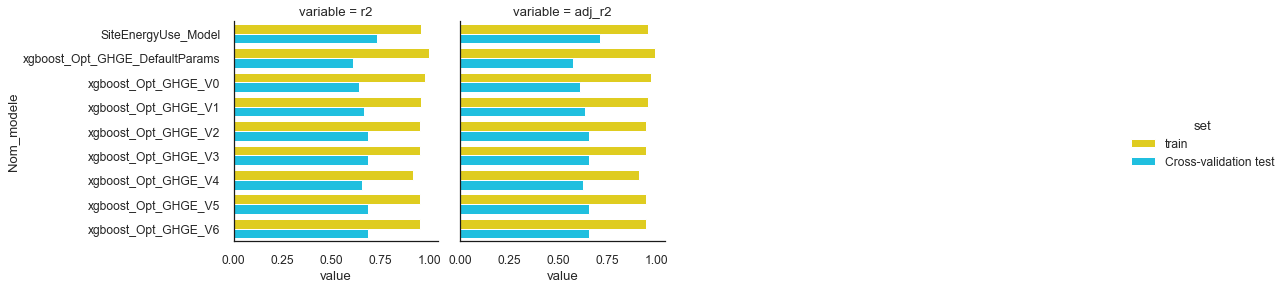

In [84]:
plot_model_comparison(summaryGridSearchCV_GHGE, model_name_var='Nom_modele', score_list=['r2', 'adj_r2'])

In [85]:
best_model = 'xgboost_Opt_GHGE_V2'
best_param = summaryGridSearchCV_GHGE.loc[summaryGridSearchCV_GHGE.loc[:, 'Nom_modele'] == best_model, 'best_param'].values[0]
best_param

"{'regressor__model__booster': 'gbtree', 'regressor__model__colsample_bytree': 0.5, 'regressor__model__learning_rate': 0.3, 'regressor__model__max_depth': 2, 'regressor__model__n_estimators': 400, 'regressor__model__subsample': 0.8}"

In [86]:
fitted_param_GHGE = {'booster': 'gbtree', 'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 2,'n_estimators': 400,'subsample':0.8}

In [87]:
estimatorGHGE = xgb.XGBRegressor(objective ='reg:squarederror', **fitted_param_GHGE)
pipeGHGE = Pipeline([
                 ("preprocessor", preprocessing_pipeline),
                 ("model", estimatorGHGE)
                 ])

In [88]:
final_modelGHGE = TransformedTargetRegressor(regressor=pipeGHGE, func=np.log, inverse_func=np.exp)
final_modelGHGE.fit(X_trainGHGE, y_trainGHGE)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       RobustScaler(),
                                                                                       ['BuildingAge',
                                                                                        'NumberofBuildings',
                                                                                        'NumberofFloors',
                                                                                        'ENERGYSTARScore',
                                                                                        'PropertyGFATotal',
                                                                                        'PropertyGFAParking',
                                                                                        'PropertyGFABuilding(s)',
                                                                                        'LargestPropertyUseTypeGFA',
                                                                                        'SecondLargestProper...
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.3,
                                                                   max_delta_step=None,
                                                                   max_depth=2,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=400,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=None,
                                                                   reg_alpha=None,
                                                                   reg_lambda=None,
                                                                   scale_pos_weight=None,
                                                                   subsample=0.8,
                                                                   tree_method=None,
                                                                   validate_parameters=None,
                                                                   verbosity=None))]))

## Evaluation graphique

In [89]:
cv=5
score=adj_r2

### Courbe d'apprentissage

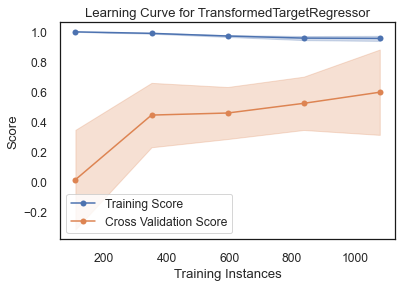

In [90]:
learning_curve = LearningCurve(final_modelGHGE, scoring=score, cv=cv)
learning_curve.fit(X_trainGHGE, y_trainGHGE)
learning_curve.finalize()
plt.savefig('figures/learning_curve_final_modelGHGE.png', bbox_inches='tight', dpi=dpi)

### Courbe de validation

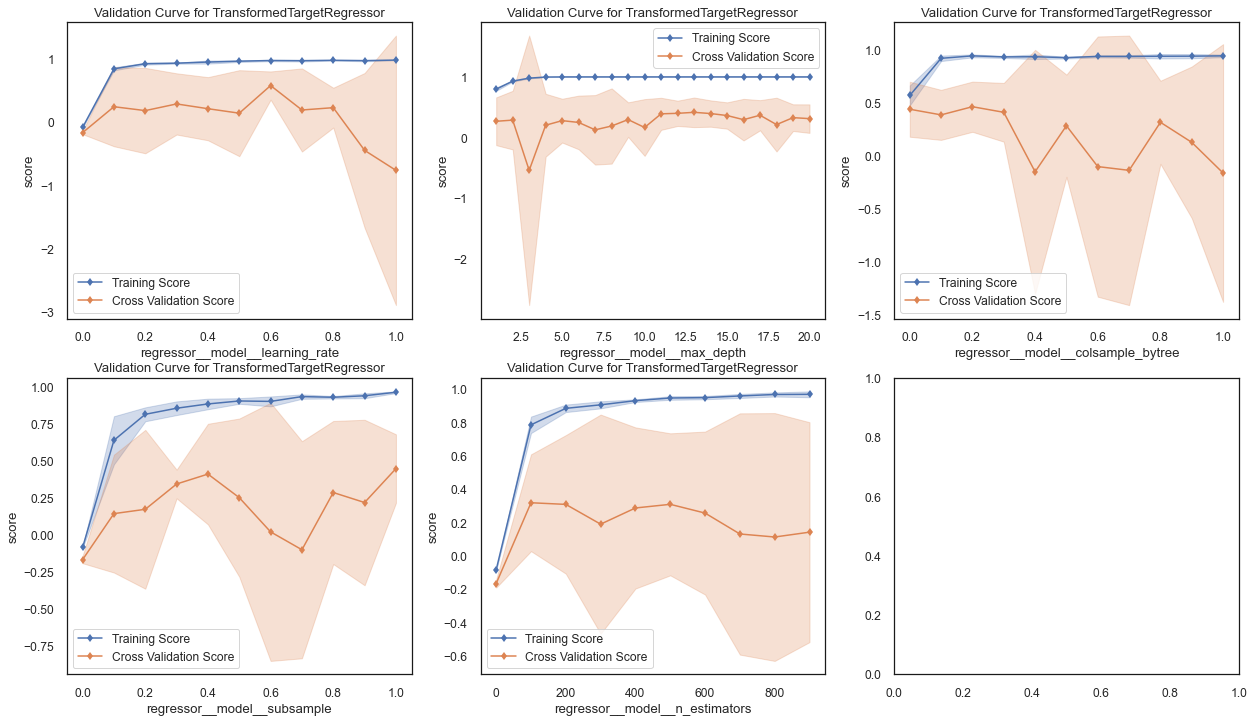

In [91]:
param_list = ["regressor__model__learning_rate", "regressor__model__max_depth", "regressor__model__colsample_bytree", 
              "regressor__model__subsample", "regressor__model__n_estimators"]

param_list_ranges = [np.arange(0,1.1, 0.1), np.arange(1,21, 1), np.arange(0,1.1, 0.10), 
                     np.arange(0,1.1, 0.1), np.arange(0,1000, 100)]

plot_validation_curves(final_modelGHGE, param_list, param_list_ranges, X_GHGE, y_GHGE, cv=cv, scoring=score, nrows=2, sharey=False)

### Importance des variables

In [92]:
# Choix du nombre de variables à afficher
n_var = 15

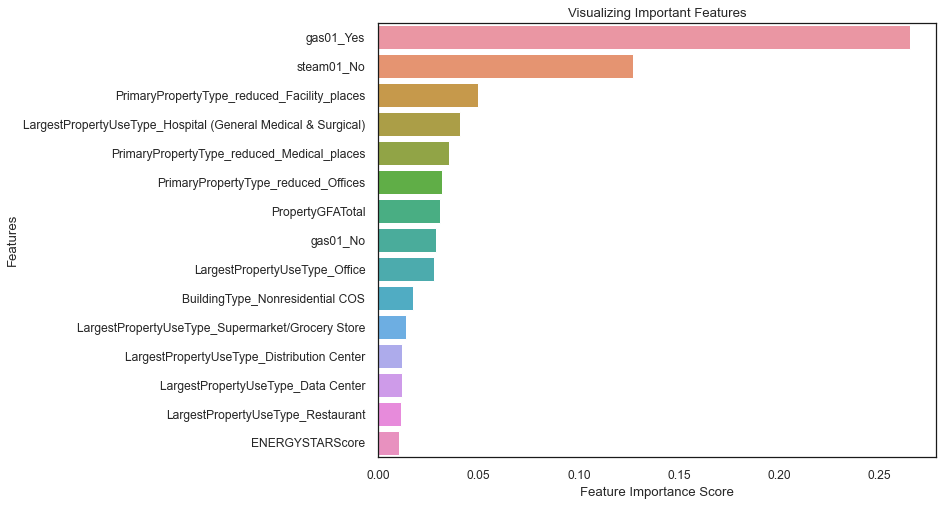

In [93]:
plot_feature_importance(final_modelGHGE, n_var, figsize=(10, 8), savefig='figures/GHGE_finalModel_feature_importance.png')

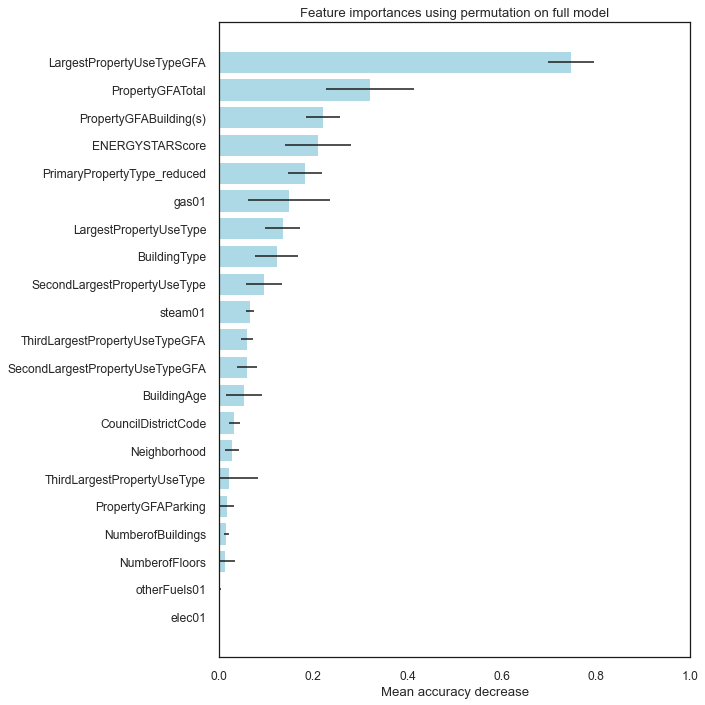

In [94]:
plot_feature_permutation_importance(final_modelGHGE, X_trainGHGE, y_trainGHGE, scoring='r2', color="lightblue", n_repeats=100, random_state=0, 
                                    savefig='figures/GHGE_finalModel_featurePermutations_TrainSet.png')

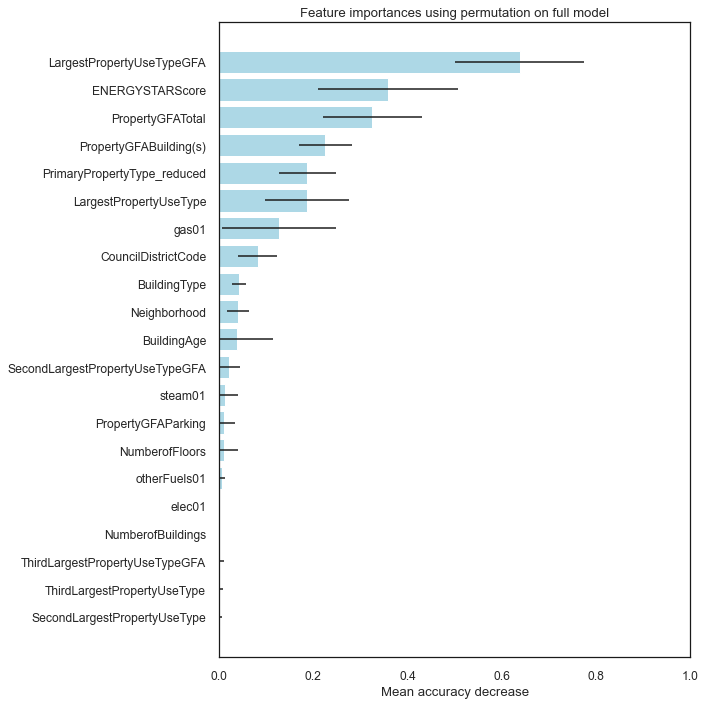

In [95]:
plot_feature_permutation_importance(final_modelGHGE, X_testGHGE, y_testGHGE, scoring='r2', color="lightblue", n_repeats=100, random_state=0, 
                                    savefig='figures/GHGE_finalModel_featurePermutations_TestSet.png')

### Valeurs prédites vs. valeurs observées

In [96]:
y_test_predGHGE = final_modelGHGE.predict(X_testGHGE)

#### Toutes données

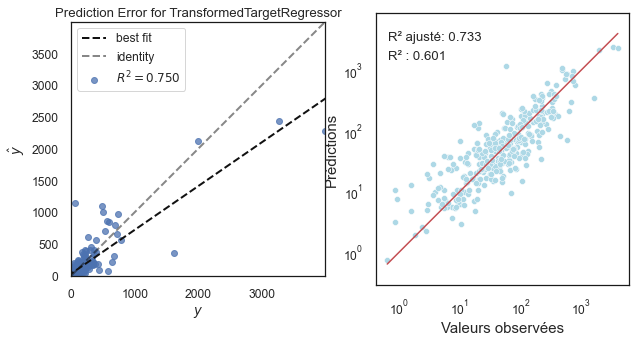

In [97]:
plot_predictions(final_modelGHGE, X_trainGHGE, y_trainGHGE, X_testGHGE, y_testGHGE, y_test_predGHGE, color='lightblue', savefig='figures/GHGE_finalModel_predictions.png')

#### Par type d'usage

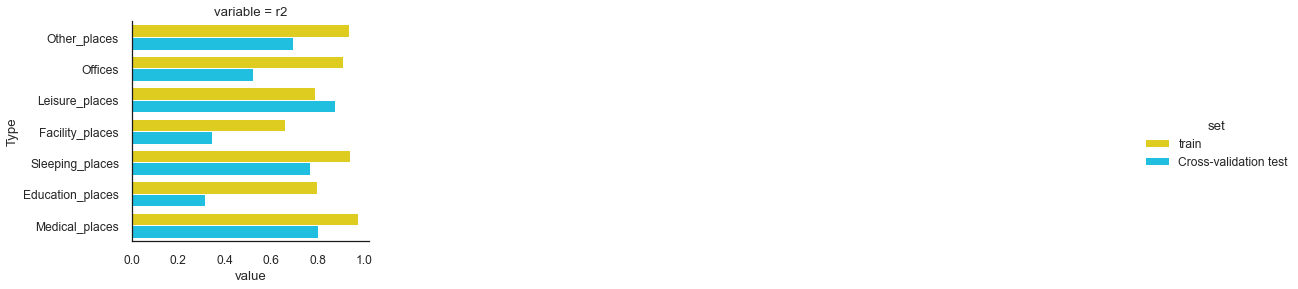

In [98]:
barplot_prediction_Errors(final_modelGHGE, X_trainGHGE, y_trainGHGE, X_testGHGE, y_testGHGE, hue='PrimaryPropertyType_reduced', 
                          metric='r2', color='lightblue', savefig='figures/GHGE_finalModel_predictions_byPropertyTypeRed_R2.png')

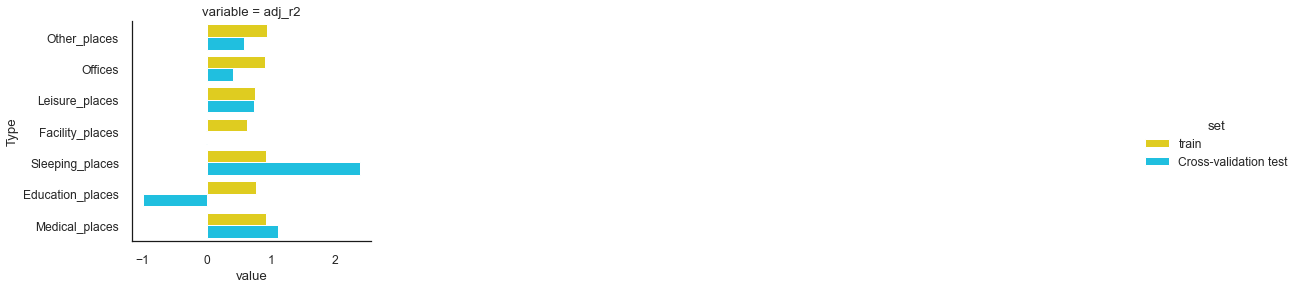

In [99]:
barplot_prediction_Errors(final_modelGHGE, X_trainGHGE, y_trainGHGE, X_testGHGE, y_testGHGE, hue='PrimaryPropertyType_reduced', 
                          metric='adj_r2', color='lightblue', savefig='figures/GHGE_finalModel_predictions_byPropertyTypeRed_R2adj.png')

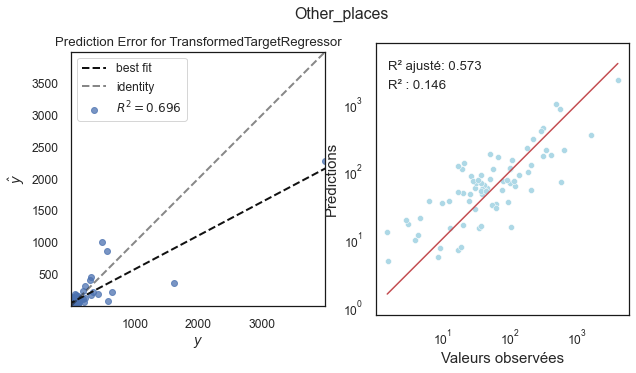

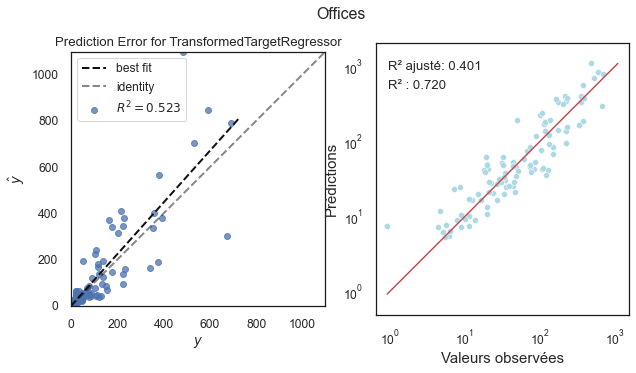

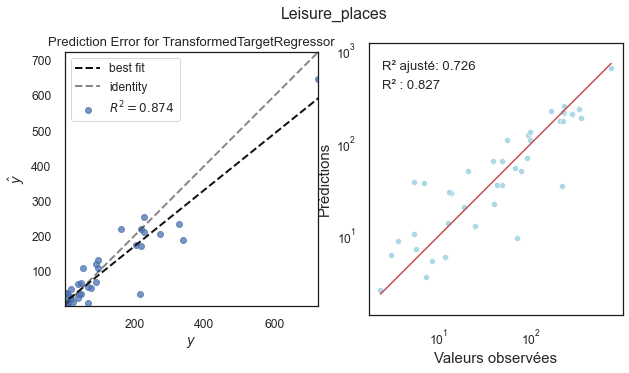

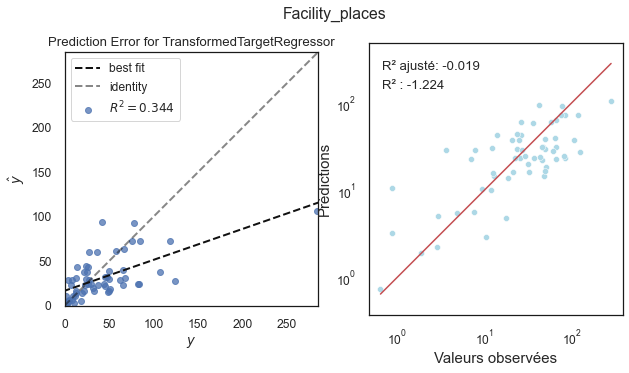

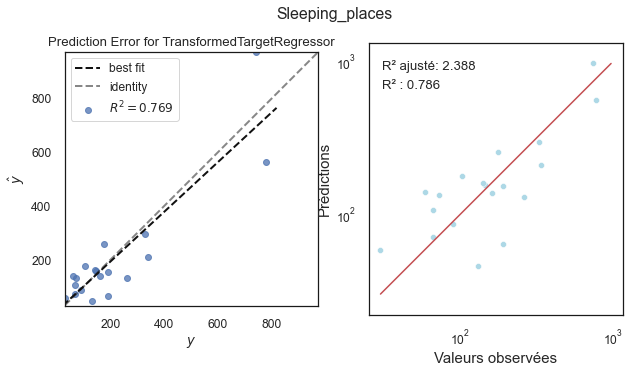

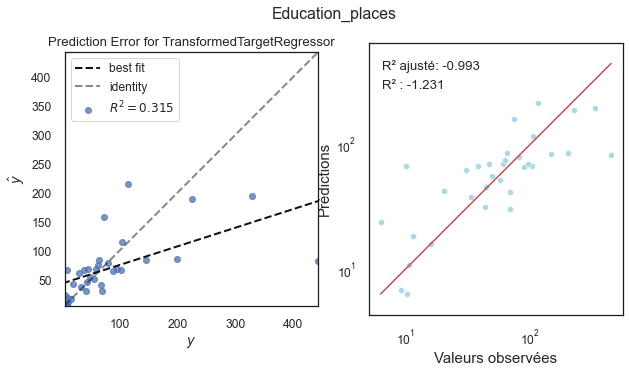

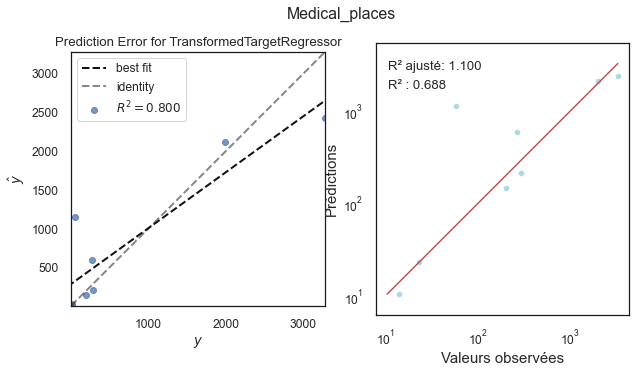

In [100]:
plot_predictions(final_modelGHGE, X_trainGHGE, y_trainGHGE, X_testGHGE, y_testGHGE, y_test_predGHGE, hue='PrimaryPropertyType_reduced', color='lightblue', savefig='figures/GHGE_finalModel_predictions_ByPropertyTypeRed.png')

### Distribution des résidus

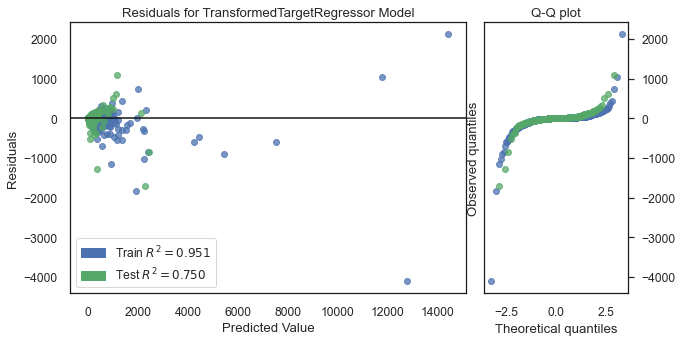

<AxesSubplot:title={'center':'Residuals for TransformedTargetRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [101]:
fig = plt.figure(figsize=(10, 5))
visualizer = ResidualsPlot(final_modelGHGE, hist=False, qqplot=True, si_fitted=True)
visualizer.fit(X_trainGHGE, y_trainGHGE)  # Fit the training data to the visualizer
visualizer.score(X_testGHGE, y_testGHGE)  # Evaluate the model on the test data
visualizer.show() 

# Partie 4 - Effet de l'Energy Star Score sur la prédiction des émissions de CO2

## Choix des variables à utiliser

In [102]:
# Retrait de l'Energy Star Score
num_var.remove('ENERGYSTARScore') 

In [103]:
# Verification des variables numériques prises en compte
num_var

['BuildingAge',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA']

## Création des jeux d'entrainement et de validation

In [104]:
# Set train size
train_size = 0.8
stratify_var = 'PrimaryPropertyType_reduced'

In [105]:
# Creation jeu de test et train
y_GHGE = df.loc[:, target_var]
X_GHGE_withoutESS = df.loc[:, num_var + cat_var]

X_trainGHGE_withoutESS, X_testGHGE_withoutESS, y_trainGHGE_withoutESS, y_testGHGE_withoutESS= train_test_split(X_GHGE_withoutESS, y_GHGE, train_size=train_size, stratify=X.loc[:,stratify_var], random_state=100) 

In [106]:
# Préparation des données via pipeline
preprocessing_pipeline = ColumnTransformer([
    ("num", num_scaler, num_var),
    ("cat", cat_scaler, cat_var)
])

In [107]:
estimatorGHGE = xgb.XGBRegressor(objective ='reg:squarederror', **fitted_param_GHGE)
pipeGHGE_withoutESS = Pipeline([
                 ("preprocessor", preprocessing_pipeline),
                 ("model", estimatorGHGE)
                 ])

In [108]:
final_modelGHGE_withoutESS = TransformedTargetRegressor(regressor=pipeGHGE_withoutESS, func=np.log, inverse_func=np.exp)
final_modelGHGE_withoutESS.fit(X_trainGHGE_withoutESS, y_trainGHGE_withoutESS)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       RobustScaler(),
                                                                                       ['BuildingAge',
                                                                                        'NumberofBuildings',
                                                                                        'NumberofFloors',
                                                                                        'PropertyGFATotal',
                                                                                        'PropertyGFAParking',
                                                                                        'PropertyGFABuilding(s)',
                                                                                        'LargestPropertyUseTypeGFA',
                                                                                        'SecondLargestPropertyUseTypeGFA',
                                                                                        'Thi...
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.3,
                                                                   max_delta_step=None,
                                                                   max_depth=2,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=400,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=None,
                                                                   reg_alpha=None,
                                                                   reg_lambda=None,
                                                                   scale_pos_weight=None,
                                                                   subsample=0.8,
                                                                   tree_method=None,
                                                                   validate_parameters=None,
                                                                   verbosity=None))]))

## Evaluation du modèle

In [109]:
# Choix du nombre de variables à afficher
n_var = 10

IMPORTANCE DES VARIABLES


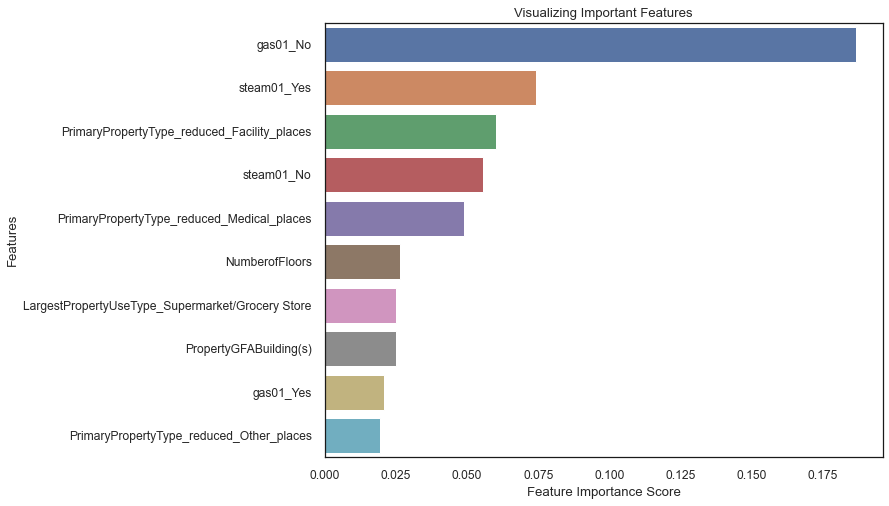

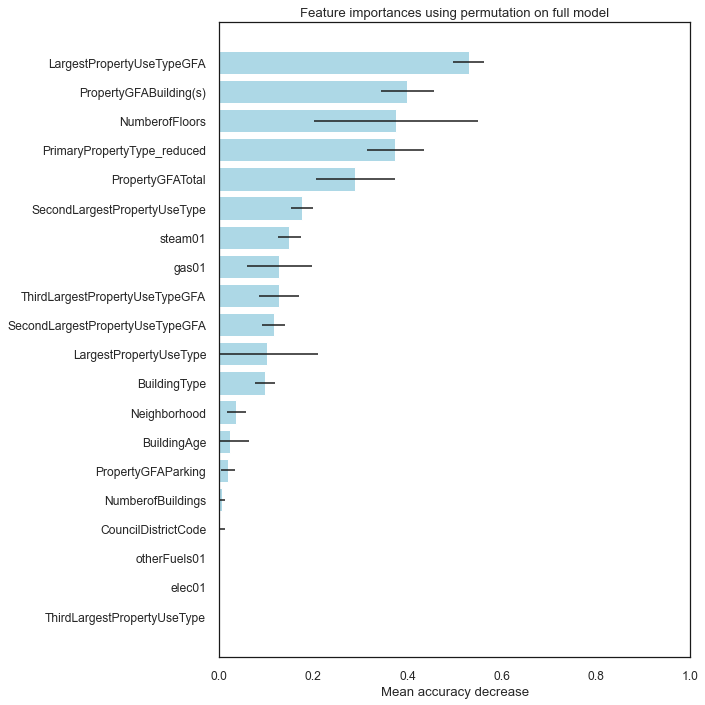

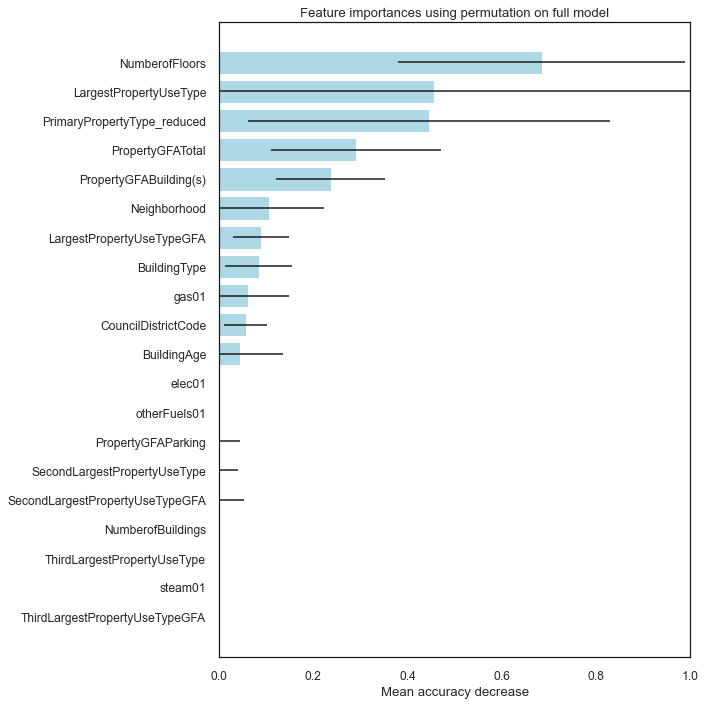

PREDICTIONS


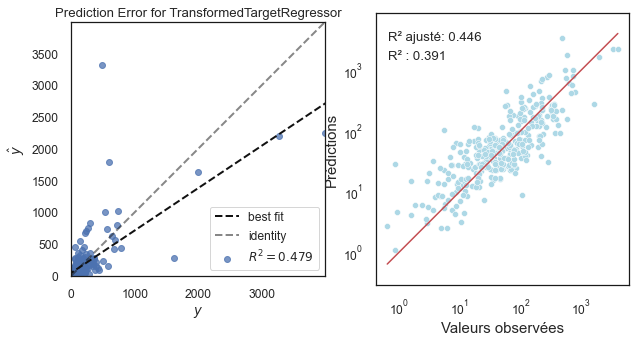

PREDICTIONS PAR TYPE DE BATIMENT
PREDICTIONS PAR TYPE DE BATIMENT-DETAILS


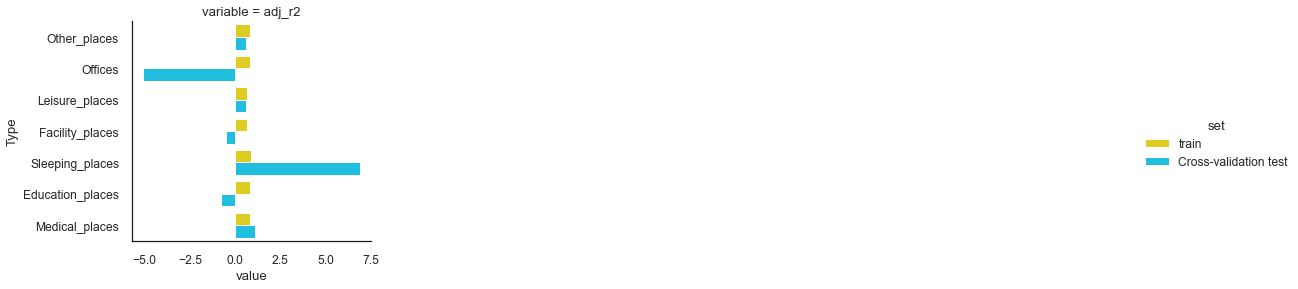

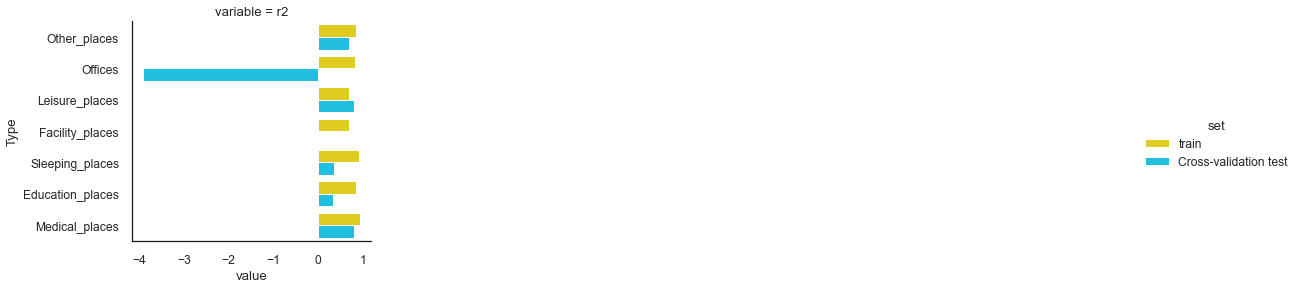

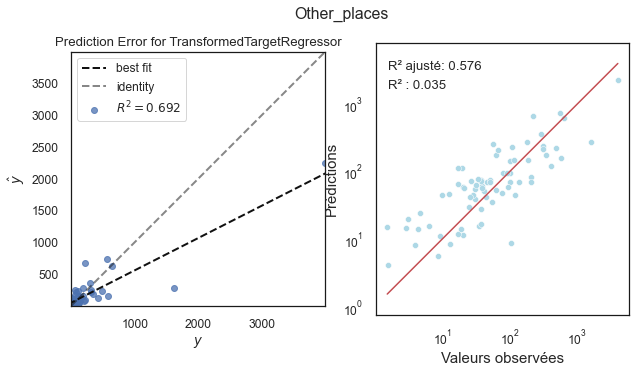

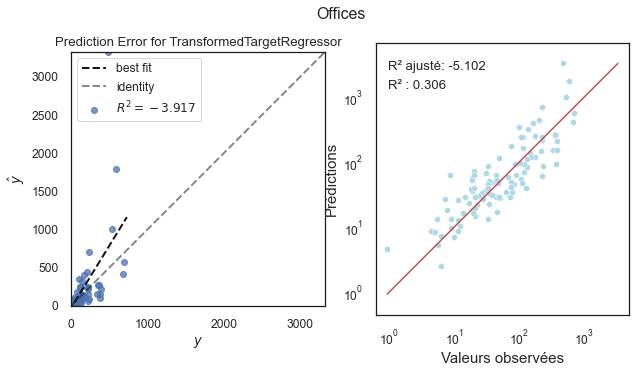

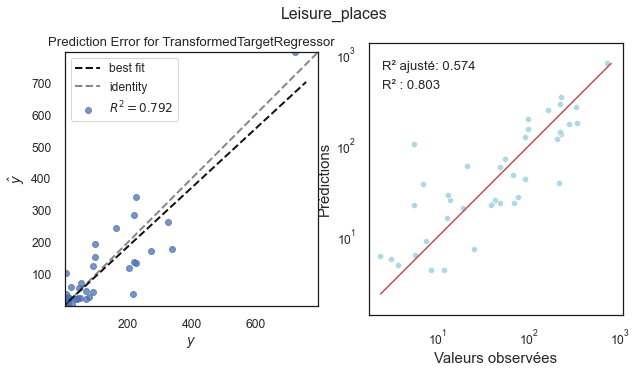

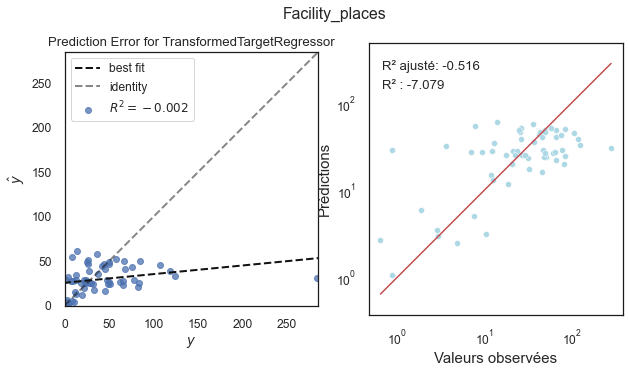

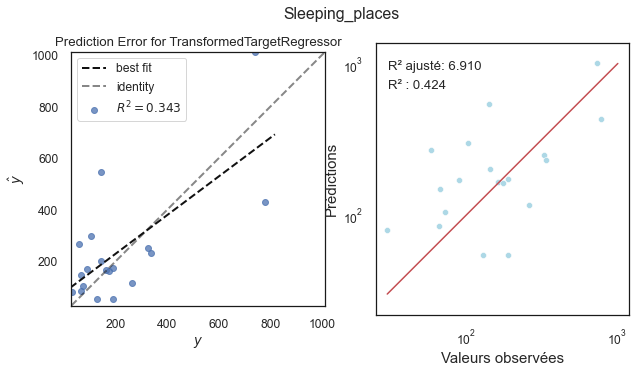

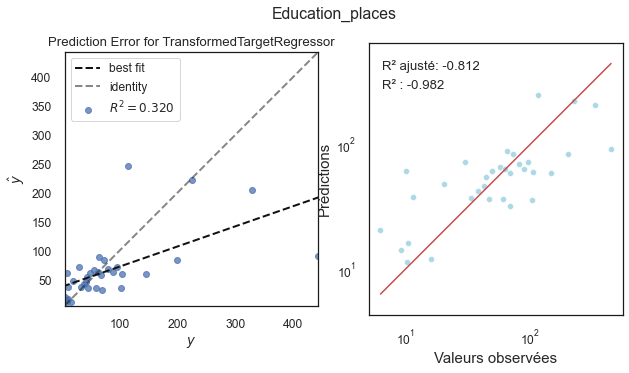

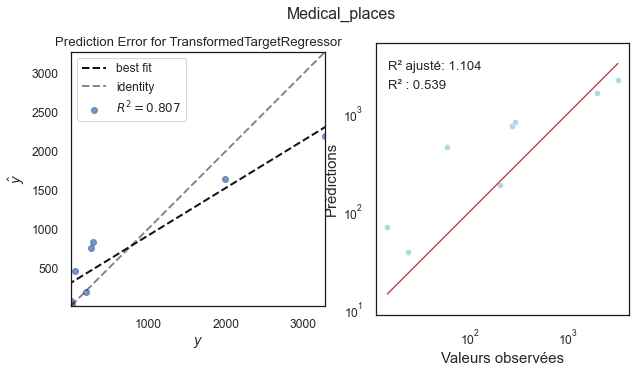

DISTRIBUTION DES RESIDUS


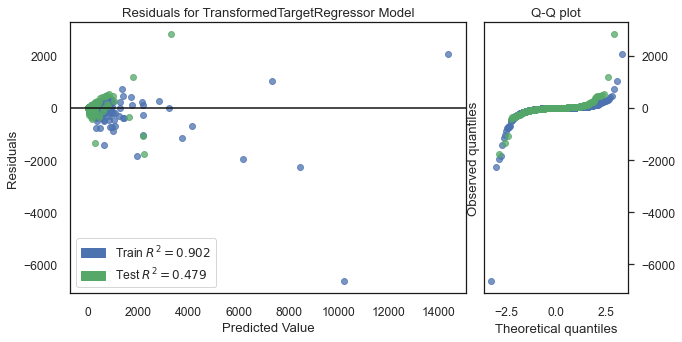

In [115]:
evaluate_model(final_modelGHGE_withoutESS, X_trainGHGE_withoutESS, y_trainGHGE_withoutESS, 
               X_testGHGE_withoutESS, y_testGHGE_withoutESS, n_var=n_var, model_name_for_figsave="modelGHGE_withoutESS_test")

## Quantification de l'effet de l'Energy Star Score

### Extraction des résultats

In [111]:
model_adjr2 = pd.DataFrame(columns=['model','set', 'adj_R²'], dtype='float')
model_adjr2

,model,set,adj_R²


In [112]:
model_adjr2 = model_adjr2.append({'model':'with_ESS', 'set':'train', 'adj_R²': adj_r2(final_modelGHGE, X_trainGHGE, y_trainGHGE)}, ignore_index=True)
model_adjr2 = model_adjr2.append({'model':'with_ESS', 'set':'test', 'adj_R²': adj_r2(final_modelGHGE, X_testGHGE, y_testGHGE)}, ignore_index=True)
model_adjr2 = model_adjr2.append({'model':'without_ESS', 'set':'train', 'adj_R²': adj_r2(final_modelGHGE_withoutESS, X_trainGHGE_withoutESS, y_trainGHGE_withoutESS)}, ignore_index=True)
model_adjr2 = model_adjr2.append({'model':'without_ESS', 'set':'test', 'adj_R²': adj_r2(final_modelGHGE_withoutESS, X_testGHGE_withoutESS, y_testGHGE_withoutESS)}, ignore_index=True)
model_adjr2                

,model,set,adj_R²
0,with_ESS,train,0.951
1,with_ESS,test,0.733
2,without_ESS,train,0.901
3,without_ESS,test,0.446


### Affichage des résultats

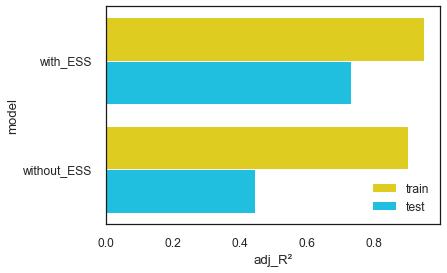

In [113]:
sns.barplot(x="adj_R²", y='model', hue="set", palette='jet_r', data=model_adjr2)
plt.legend(loc='lower right')
plt.savefig('figures/ESS_effect_on_GHGE_predictions.png', bbox_inches='tight', dpi=dpi)

**Conclusion Importance Energy Star Score (ESS):**
- Le modèle est clairement moins performant sans l'ESS. Les R² ajustés sur le train set n'est pas énormément plus faible (0.95 vs. 0.90), par contre, il passe de 0.73 à 0.45 sur le jeu de validation. 
- Par ailleurs, les performances par types de bâtiment sont clairement moins bonnes. 
- Enfin, la variabilité de l'importance des features par permutation entre le jeu d'entrainement et le jeu de validation dénote une instabilité du modèle sans l'intégration de la variable ESS.

# Bonus - Prédiction Université de Washington

In [249]:
data2016= pd.read_csv('data/2016-building-energy-benchmarking.csv')
univ2016 = data2016.loc[data2016.loc[:,'OSEBuildingID'] == 49967]
univ2016.loc[:, 'CouncilDistrictCode'] = univ2016.loc[:, 'CouncilDistrictCode'].astype('object')
univ2016

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3274,49967,2016,Campus,University,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,Seattle,WA,"98,105.000",1625049001,4,NORTHEAST,47.656,-122.310,1900,111.000,0,9320156,0,9320156,College/University,College/University,"9,320,156.000",NaN,NaN,NaN,NaN,NaN,NaN,93.800,0.000,246.600,0.000,"873,923,712.000",0.000,"84,985,240.000","192,577,488.000","657,074,389.000",0.000,0.000,False,NaN,Compliant,NaN,"11,140.560",1.200


In [250]:
# Calcul et imputation des données
univ2016.loc[:, 'BuildingAge'] = 2022-univ2016.loc[:, 'YearBuilt']
univ2016.loc[:, 'PrimaryPropertyType_reduced'] = 'Education_places'
univ2016.loc[:, 'Neighborhood'] = univ2016.loc[:, 'Neighborhood'].str.capitalize()
univ2016.loc[:, 'SecondLargestPropertyUseTypeGFA'] = 0
univ2016.loc[:, 'ThirdLargestPropertyUseTypeGFA'] = 0
univ2016.loc[:, 'SecondLargestPropertyUseType'] = "none"
univ2016.loc[:, 'ThirdLargestPropertyUseType'] = "none"
univ2016.loc[:,'steam01'] = univ2016.loc[:, 'SteamUse(kBtu)'].apply(lambda x: 'Yes' if x>0 else 'No')
univ2016.loc[:, "elec01"] = univ2016.loc[:, "Electricity(kBtu)"].apply(lambda x: 'Yes' if x>0 else 'No')
univ2016.loc[:, "gas01"] = univ2016.loc[:, "NaturalGas(kBtu)"].apply(lambda x: 'Yes' if x>0 else 'No')
univ2016.loc[:, "otherFuels01"] = 'No'
univ2016.loc[:, "ENERGYSTARScore"] = 65.420870

univ2016

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,PrimaryPropertyType_reduced,steam01,elec01,gas01,otherFuels01
3274,49967,2016,Campus,University,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,Seattle,WA,"98,105.000",1625049001,4,Northeast,47.656,-122.310,1900,111.000,0,9320156,0,9320156,College/University,College/University,"9,320,156.000",none,0,none,0,NaN,65.421,93.800,0.000,246.600,0.000,"873,923,712.000",0.000,"84,985,240.000","192,577,488.000","657,074,389.000",0.000,0.000,False,NaN,Compliant,NaN,"11,140.560",1.200,122,Education_places,Yes,Yes,No,No


In [251]:
# Selection des variables
univ_conso = univ2016.loc[:,X_test.columns]
univ_GHGE = univ2016.loc[:,X_testGHGE.columns]

In [256]:
# Prédictions
conso = final_model_Energy.predict(univ_conso)
emission = final_modelGHGE.predict(univ_GHGE)

In [274]:
# Evaluation
univ_eval = pd.DataFrame(columns=['var','value', 'set'], dtype='float')
univ_eval = univ_eval.append({'var':'consommation', 'set':'obs', 'value': univ2016['SiteEnergyUse(kBtu)'].values[0]}, ignore_index=True)
univ_eval = univ_eval.append({'var':'consommation', 'set':'pred', 'value':conso[0]}, ignore_index=True)
univ_eval = univ_eval.append({'var':'emissions', 'set':'obs', 'value': univ2016['TotalGHGEmissions'].values[0]}, ignore_index=True)
univ_eval = univ_eval.append({'var':'emissions', 'set':'pred', 'value':emission[0]}, ignore_index=True)
univ_eval                

,var,value,set
0,consommation,"873,923,712.000",obs
1,consommation,"82,285,864.000",pred
2,emissions,"11,140.560",obs
3,emissions,840.363,pred


=> Il y a un facteur 10 entre la prédiction et la valeur observée. Le modèle n'est pas adapté pour les surfaces supérieures à celles présentes dans le jeu d'entrainement. 